# Libraries

In [1]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')
import random
import scipy as sp
import numpy as np
import pandas as pd
#import joblib
#import itertools
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
#import pyarrow as pa
#import pyarrow.parquet as pq
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import StratifiedKFold
#import lightgbm as lgb
#from lightgbm import LGBMClassifier
from tqdm import tqdm

In [4]:
#Preprocessing by https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7963

# ====================================================
# Read & preprocess data and save it to disk
# ====================================================
def read_preprocess_data():
    train = pd.read_parquet(r'C:\Users\domin\Downloads\parq_data\train.parquet')
    features = train.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features]
    print('Starting training feature engineer...')
    train_num_agg = train.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)
    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    train_labels = pd.read_csv(r'C:\Users\domin\Downloads\amex-default-prediction\train_labels.csv')
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    del train_num_agg, train_cat_agg
    gc.collect()
    test = pd.read_parquet(r'C:\Users\domin\Downloads\parq_data\test.parquet')
    print('Starting test feature engineer...')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)
    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID')
    del test_num_agg, test_cat_agg
    gc.collect()
    # Save files to disk
    train.to_parquet(r'C:\Users\domin\Downloads\parq_data\train_fe.parquet')
    test.to_parquet(r'C:\Users\domin\Downloads\parq_data\test_fe.parquet')

In [ ]:
read_preprocess_data()

This method is not implemented well, there is not a big difference in memory

## Reduce RAM by changing float64 to float16 and pickling data

In [6]:
def reduce_memory_usage(df, chunk=None):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Initial Memory chunk: {:.3f}".format(start_mem))
    for col in df.columns:
        type_ = df[col].dtype
        if str(type_) != "object":
            if str(type_)[:3] == "int":
                df[col] = df[col].astype(np.int8)
            else:
                df[col] = df[col].astype(np.float16)
        else:
            df[col] = df[col].astype("category")   
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Final Memory chunk: {:.3f}".format(end_mem))
    print("Reduced by: {:.2f}".format((start_mem - end_mem) / start_mem))
    return df
chunksize=1.5*(10**5)
train_df = pd.DataFrame()
with pd.read_csv(r'C:\Users\domin\Downloads\amex-default-prediction\test_data.csv', chunksize=chunksize) as reader:
    counter=0
    for chunk in tqdm(reader):
        print(counter, flush=True)
        chunk=reduce_memory_usage(chunk)
        train_df = pd.concat([train_df, chunk])
        counter+=1
#labels=pd.read_csv(r'C:\Users\domin\Downloads\amex-default-prediction\train_labels.csv')
#labels=reduce_memory_usage(labels)
#train_df=pd.merge(train_df, labels, on='customer_ID')
train_df.to_pickle(r'C:\Users\domin\Downloads\AE_pickled\test.pkl')
del train_df
gc.collect()

0it [00:00, ?it/s]

0
Initial Memory chunk: 217.438


1it [00:13, 13.76s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
1
Initial Memory chunk: 217.438


2it [00:26, 13.30s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
2
Initial Memory chunk: 217.438


3it [00:39, 13.24s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
3
Initial Memory chunk: 217.438


4it [00:52, 12.99s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
4
Initial Memory chunk: 217.438


5it [01:04, 12.47s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
5
Initial Memory chunk: 217.438


6it [01:17, 12.73s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
6
Initial Memory chunk: 217.438


7it [01:28, 12.23s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
7
Initial Memory chunk: 217.438


8it [01:41, 12.37s/it]

Final Memory chunk: 54.296
Reduced by: 0.75
8
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


9it [01:54, 12.65s/it]

9
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


10it [02:08, 13.07s/it]

10
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


11it [02:22, 13.32s/it]

11
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


12it [02:37, 13.81s/it]

12
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


13it [02:51, 14.00s/it]

13
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


14it [03:06, 14.22s/it]

14
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


15it [03:21, 14.43s/it]

15
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


16it [03:34, 14.05s/it]

16
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


17it [03:50, 14.58s/it]

17
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


18it [04:05, 14.85s/it]

18
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


19it [04:22, 15.45s/it]

19
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


20it [04:38, 15.42s/it]

20
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


21it [04:54, 15.64s/it]

21
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


22it [05:08, 15.32s/it]

22
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


23it [05:23, 15.22s/it]

23
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


24it [05:37, 14.88s/it]

24
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


25it [05:51, 14.51s/it]

25
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


26it [06:05, 14.30s/it]

26
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


27it [06:19, 14.16s/it]

27
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


28it [06:32, 13.82s/it]

28
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


29it [06:45, 13.55s/it]

29
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


30it [06:57, 13.32s/it]

30
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


31it [07:10, 13.19s/it]

31
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


32it [07:23, 13.10s/it]

32
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


33it [07:37, 13.26s/it]

33
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


34it [07:50, 13.27s/it]

34
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


35it [08:04, 13.54s/it]

35
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


36it [08:18, 13.60s/it]

36
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


37it [08:35, 14.60s/it]

37
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


38it [08:49, 14.35s/it]

38
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


39it [09:05, 15.02s/it]

39
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


40it [09:19, 14.59s/it]

40
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


41it [09:32, 14.22s/it]

41
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


42it [09:45, 13.95s/it]

42
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


43it [09:59, 13.77s/it]

43
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


44it [10:12, 13.66s/it]

44
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


45it [10:25, 13.54s/it]

45
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


46it [10:41, 14.23s/it]

46
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


47it [10:57, 14.54s/it]

47
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


48it [11:12, 14.86s/it]

48
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


49it [11:27, 14.70s/it]

49
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


50it [11:40, 14.48s/it]

50
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


51it [11:54, 14.24s/it]

51
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


52it [12:08, 14.21s/it]

52
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


53it [12:21, 13.80s/it]

53
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


54it [12:34, 13.44s/it]

54
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


55it [12:48, 13.61s/it]

55
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


56it [13:02, 13.76s/it]

56
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


57it [13:17, 14.31s/it]

57
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


58it [13:31, 14.06s/it]

58
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


59it [13:44, 13.85s/it]

59
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


60it [13:57, 13.57s/it]

60
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


61it [14:11, 13.61s/it]

61
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


62it [14:25, 13.80s/it]

62
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


63it [14:39, 13.83s/it]

63
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


64it [14:56, 14.87s/it]

64
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


65it [15:12, 15.05s/it]

65
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


66it [15:27, 14.97s/it]

66
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


67it [15:41, 14.89s/it]

67
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


68it [15:56, 14.71s/it]

68
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


69it [16:12, 15.25s/it]

69
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


70it [16:27, 15.06s/it]

70
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


71it [16:43, 15.40s/it]

71
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


72it [16:59, 15.66s/it]

72
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


73it [17:12, 14.93s/it]

73
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


74it [17:26, 14.62s/it]

74
Initial Memory chunk: 217.438
Final Memory chunk: 54.296
Reduced by: 0.75


75it [17:40, 14.40s/it]

75
Initial Memory chunk: 164.908
Final Memory chunk: 41.245
Reduced by: 0.75


76it [17:51, 14.10s/it]


0

In [5]:
df = pd.read_pickle(r'C:\Users\domin\Downloads\AE_pickled\train.pkl')

KeyboardInterrupt: 

In [ ]:
df

In [ ]:
df[df.columns[1:-1]]

This helps a lot! =)

# Data analysis

In [6]:
df = pd.read_pickle(r'C:\Users\domin\Downloads\AE_pickled\train.pkl')

## Categorical variables

### General remarks

In [4]:
def isNaN(num):
    return num != num
def completeness(col):
    return (len(col) -sum([1 for x in col if isNaN(x)]))/len(col)

In [7]:
def number_cat(list_of_categories):
    """Function to cast categorical vatriables as numeric, output - dictionary of mappings"""
    unique_values = list_of_categories.values.unique()
    corresponding_map = {}
    i = 0
    for q in unique_values:
        corresponding_map[q] = i
        i +=1
    return corresponding_map

In [8]:
cat_vars = categorical_variables

In [8]:
df = df[cat_vars]
gc.collect()

NameError: name 'df' is not defined

In [9]:
mapping = number_cat(df['D_63'])
df['D_63'] = [mapping[q] for q in df['D_63']]
mapping = number_cat(df['D_64'])
df['D_64'] = [mapping[q] for q in df['D_64']]

In [3]:
#from matplotlib import pyplot as plt

In [4]:
#fig = plt.figure(figsize = (15,20))
#ax = fig.gca()
#df.hist(ax = ax, by = 'target')

In [9]:
for col in df.columns:
    print('Completeness of ' + str(col) +': ' + '{:.2%}'.format(completeness(df[col])))

Completeness of B_30: 99.96%
Completeness of B_38: 99.96%
Completeness of D_114: 96.81%
Completeness of D_116: 96.81%
Completeness of D_117: 96.81%
Completeness of D_120: 96.81%
Completeness of D_126: 97.89%
Completeness of D_63: 100.00%
Completeness of D_64: 100.00%
Completeness of D_66: 11.27%
Completeness of D_68: 96.09%
Completeness of target: 100.00%


### Correlations

In [27]:
df.corr().style.background_gradient(cmap='coolwarm')

KeyboardInterrupt: 

Not big correleration overall, but its worth noting that B_38 and B_30 are strongly connected to our goal value.

### Histograms with target distribution

In [23]:
def generate_categorized_histogram(df, hist_col, category_column,  column_number):
    num_rows = int(len(hist_col)/3 + (len(hist_col) % 3 > 1))
    fig = make_subplots(rows = num_rows, cols = column_number, subplot_titles = hist_col)
    #fig = go.Figure()
    categories = df[category_column].unique()
    traces = []
    rn = cn = 1
    for col in hist_col:
        for cat in categories:   
            values = df[df[category_column] == cat]
            #temp = values[col].value_counts(dropna=False, normalize=True).sort_index().rename('count')
            temp = pd.DataFrame(values[col].value_counts(dropna=False, normalize=True).sort_index().rename('count'))
            temp.index.name = 'value'
            temp.reset_index(inplace=True)
            fig.append_trace(go.Bar(
            y=temp['count'],
            x=temp.index,
            name= col + ', target: ' + str(cat)
            ),rn,cn)
        #if we hit the line limit for plots
        if cn + 1 > column_number:
            rn +=1
            cn = 1
        else:
            cn +=1
    
    fig.update_layout(barmode='group', title = 'Distribution of categorical values grouped by target value.',
                     showlegend=False, height=800, width=950)
    return fig

In [26]:
generate_categorized_histogram(df,cat_vars[:-1] , 'target', 3).show()

KeyError: 'D_66'

For most of variables we can see significant differences between groups with traget == 0 and target == 1, which combined with high completeness of this variables may indicate that they will be usefull in modelling.

### Dumb tree for component analysis

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [14]:
clean_cols = ['B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68', 'target']
to_train = df[clean_cols].dropna()
to_train.shape

(5308703, 11)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(to_train[clean_cols[:-1]].values,to_train[clean_cols[-1]].values,
                                                    stratify=to_train[clean_cols[-1]].values, random_state = 42)
print('Train data shape: ' + str(X_train.shape)) 
print('Test data shape: ' + str(X_test.shape)) 

Train data shape: (3981527, 10)
Test data shape: (1327176, 10)


In [16]:
tree= DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 1, min_samples_split = 2)
tree.fit(X_train, y_train)
print('Dumb tree dumb score  on training data: ' + '{:.2%}'.format(tree.score(X_train,y_train)))
print('Dumb tree dumb score  on test data: ' + '{:.2%}'.format(tree.score(X_test,y_test)))

Dumb tree dumb score  on training data: 82.34%
Dumb tree dumb score  on test data: 81.85%


In [18]:
tree.predict(X_test)

array([1, 0, 1, ..., 1, 1, 0], dtype=int8)

In [26]:
amex_metric_mod(y_test, tree.predict(X_test))

0.13946194856762237

In [77]:
params = {'min_samples_leaf' : [1, 10, 20] , 'min_samples_split' : [2, 8, 20], 'max_depth' :[4, 6, 8, 20]} 

In [78]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(), params, cv = 5)
grid_search.fit(X_train, y_train)
print('Best params: {}'.format(grid_search.best_params_))
print('Best score: {:2f}'.format(grid_search.best_score_))

Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.817850


In [ ]:
print('Best params: {}'.format(grid_search.best_params_))
print('Best score: {:2f}'.format(grid_search.best_score_))

In [20]:
def feature_importance(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align = 'center')
    plt.yticks(np.arange(n_features), clean_cols[:-1])
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

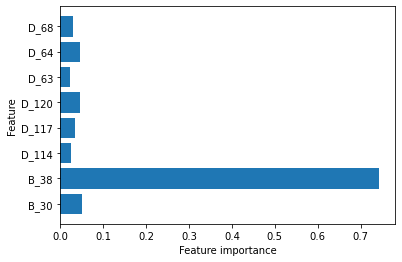

In [28]:
feature_importance(tree)

In [27]:
clean_cols = ['B_38', 'D_114', 'D_117', 'D_120', 'D_63', 'D_64', 'D_68', 'target']
to_train = df[clean_cols].dropna()
to_train.shape
X_train, X_test, y_train, y_test = train_test_split(to_train[clean_cols[:-1]].values,to_train[clean_cols[-1]].values,
                                                    stratify=to_train[clean_cols[-1]].values, random_state = 42)
print('Train data shape: ' + str(X_train.shape)) 
print('Test data shape: ' + str(X_test.shape)) 
tree= DecisionTreeClassifier(max_depth = 20, min_samples_leaf = 1, min_samples_split = 2)
tree.fit(X_train, y_train)
print('Dumb tree dumb score  on training data: ' + '{:.2%}'.format(tree.score(X_train,y_train)))
print('Dumb tree dumb score  on test data: ' + '{:.2%}'.format(tree.score(X_test,y_test)))

Train data shape: (3981527, 8)
Test data shape: (1327176, 8)
Dumb tree dumb score  on training data: 82.02%
Dumb tree dumb score  on test data: 81.72%


##  All features

In [5]:
df = pd.read_pickle(r'C:\Users\domin\Downloads\AE_pickled\train.pkl')

In [10]:
df.shape

(5531451, 191)

### Correlations within the data

In [10]:
cors = df.corr().style.background_gradient(cmap='coolwarm')
cors

In [11]:
noticible_corrs = {}
for col, row in enumerate(cors.index):
    for i in range(col):
        cor =  abs(cors.loc[row, cors.columns[i]])
        if (cor >= 0.7) & (row != cors.columns[i]):
            noticible_corrs[row] = {'with' : cors.columns[i], 'value' : round(cor,4)}
correlations = pd.DataFrame({'Feature' : noticible_corrs.keys(),
                             '2nd_feature': [noticible_corrs[key]['with'] for key in noticible_corrs.keys()],
                            'Absolute correlation' : [noticible_corrs[key]['value'] for key in noticible_corrs.keys()]})

AttributeError: 'Styler' object has no attribute 'loc'

In [ ]:
correlations.sort_values(by = 'Absolute correlation', ascending = False).reset_index(drop = True)

In [ ]:
cors['target'].sort_values()

In [ ]:
occurances = list(correlations['Feature']) + (list(correlations['2nd_feature']))

In [ ]:
for q in list(set(occurances)): print(q + ' occured ' + str(occurances.count(q)) + ' times.')
del noticible_corrs, correlations, occurances, cors
gc.collect()

In [ ]:
print('Unique customers in dataset: ' + "{:,}".format(len(df['customer_ID'].unique())).replace(",", " "))
print('Average entries per customer: ' + str(round(np.mean(df[['customer_ID', 'S_2']].groupby(by = 'customer_ID').count())[0],2)))
print('Median entries per customer: ' + str(round(np.median(df[['customer_ID', 'S_2']].groupby(by = 'customer_ID').count()),2)))
print('Amount of continous variables: ' + str(len(continous_variables)))
print('Amount of categorical variables: ' + str(len(categorical_variables)))

### Completeness

In [11]:
comp = {}
for col in df.columns:
    #comp.append(completeness(df[col]))
    comp[col] =completeness(df[col]) 
    #print('Completeness of ' + str(col) +': ' + '{:.2%}'.format(completeness(df[col])))
comp = {k: v for k, v in sorted(comp.items(), key=lambda item: item[1])}
comp

{'D_87': 0.000698731670948545,
 'D_88': 0.0010854294831500813,
 'D_108': 0.005231538704763,
 'D_110': 0.005664698105433818,
 'D_111': 0.005664698105433818,
 'B_39': 0.006080140635793393,
 'D_73': 0.01009789293984526,
 'B_42': 0.012922106694970271,
 'D_134': 0.03519854012988635,
 'D_135': 0.03519854012988635,
 'D_136': 0.03519854012988635,
 'D_137': 0.03519854012988635,
 'D_138': 0.03519854012988635,
 'R_9': 0.05650108805085682,
 'B_29': 0.06895405925136099,
 'D_106': 0.09786744924613813,
 'D_132': 0.09808945247820147,
 'D_49': 0.09862403192218461,
 'R_26': 0.11015283331624921,
 'D_76': 0.11253774100141174,
 'D_66': 0.11269267322443967,
 'D_42': 0.1430572195252204,
 'D_142': 0.17073422507042005,
 'D_53': 0.26157078856885835,
 'D_82': 0.2662659399857289,
 'D_50': 0.4319027683694568,
 'B_17': 0.4327712565834896,
 'D_105': 0.453772436924778,
 'D_56': 0.4592841914354841,
 'S_9': 0.4696431370358338,
 'D_77': 0.5455239502257183,
 'D_43': 0.7001878892174946,
 'S_27': 0.7467328192909961,
 'D_46

In [12]:
to_del = [       "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_66",
        "D_68"]
for q in to_del: del comp[q]

In [13]:
for key in comp.copy().keys():
    if comp[key] == 1: 
        del comp[key]
comp

{'D_87': 0.000698731670948545,
 'D_88': 0.0010854294831500813,
 'D_108': 0.005231538704763,
 'D_110': 0.005664698105433818,
 'D_111': 0.005664698105433818,
 'B_39': 0.006080140635793393,
 'D_73': 0.01009789293984526,
 'B_42': 0.012922106694970271,
 'D_134': 0.03519854012988635,
 'D_135': 0.03519854012988635,
 'D_136': 0.03519854012988635,
 'D_137': 0.03519854012988635,
 'D_138': 0.03519854012988635,
 'R_9': 0.05650108805085682,
 'B_29': 0.06895405925136099,
 'D_106': 0.09786744924613813,
 'D_132': 0.09808945247820147,
 'D_49': 0.09862403192218461,
 'R_26': 0.11015283331624921,
 'D_76': 0.11253774100141174,
 'D_42': 0.1430572195252204,
 'D_142': 0.17073422507042005,
 'D_53': 0.26157078856885835,
 'D_82': 0.2662659399857289,
 'D_50': 0.4319027683694568,
 'B_17': 0.4327712565834896,
 'D_105': 0.453772436924778,
 'D_56': 0.4592841914354841,
 'S_9': 0.4696431370358338,
 'D_77': 0.5455239502257183,
 'D_43': 0.7001878892174946,
 'S_27': 0.7467328192909961,
 'D_46': 0.7809437342932262,
 'S_3':

In [21]:
def target_based_inputation(df, col_name, target_col, shady = 0):
    """Function inputs mean for different target groups"""
    if shady:
        mean0 = round(np.nanmean(df[df[target_col] == 0][col_name].astype('float64')),4)
        mean1 = round(np.nanmean(df[df[target_col] == 1][col_name].astype('float64')),4) 
        work_list = [a*b for a,b in zip(df[col_name], df[target_col])]
        work_list = [x if not isNaN(x) else mean1 if x > 0 else mean0 for x in work_list]
    else:
        mean = round(np.nanmean(df[col_name].astype('float64')),4) 
        work_list = [x if not isNaN(x) else mean for x in df[col_name]]        
    return work_list

In [16]:
# Removing some of least populated columns for now
least_populated = [
'D_87','D_88','D_108','D_110','D_111','B_39','D_73','B_42','D_134','D_135'
,'D_136','D_137','D_138','R_9','B_29','D_106','D_132','D_49','R_26','D_76','D_66','D_42','D_142','D_53','D_82']

In [17]:
list(comp.keys())[17]

'D_49'

In [18]:
for q in least_populated:
    if q in comp.keys():
        del comp[q]
print('Before trimming : '+ str(df.shape))
df = df[[x for x in df.columns if x not in least_populated]]
print('After trimming : '+ str(df.shape))

Before trimming : (5531451, 191)
After trimming : (5531451, 166)


In [19]:
df.dropna().shape

(97534, 166)

In [22]:
for col in tqdm(comp.keys()):
    df[col] = target_based_inputation(df, col, 'target')

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [03:12<00:00,  2.19s/it]


In [23]:
df.dropna().shape

(5308703, 166)

In [24]:
df.to_pickle('phase_1_1.pkl')

#### Categorical variables completeness

In [34]:
categorical_variables = [x for x in categorical_variables if x not in least_populated]
categorical_variables

['B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_68',
 'target']

b_30 

array([[<AxesSubplot:title={'center':'B_30'}>,
        <AxesSubplot:title={'center':'B_38'}>,
        <AxesSubplot:title={'center':'D_114'}>],
       [<AxesSubplot:title={'center':'D_116'}>,
        <AxesSubplot:title={'center':'D_117'}>,
        <AxesSubplot:title={'center':'D_120'}>],
       [<AxesSubplot:title={'center':'D_126'}>,
        <AxesSubplot:title={'center':'D_63'}>,
        <AxesSubplot:title={'center':'D_64'}>],
       [<AxesSubplot:title={'center':'D_68'}>,
        <AxesSubplot:title={'center':'target'}>, <AxesSubplot:>]],
      dtype=object)

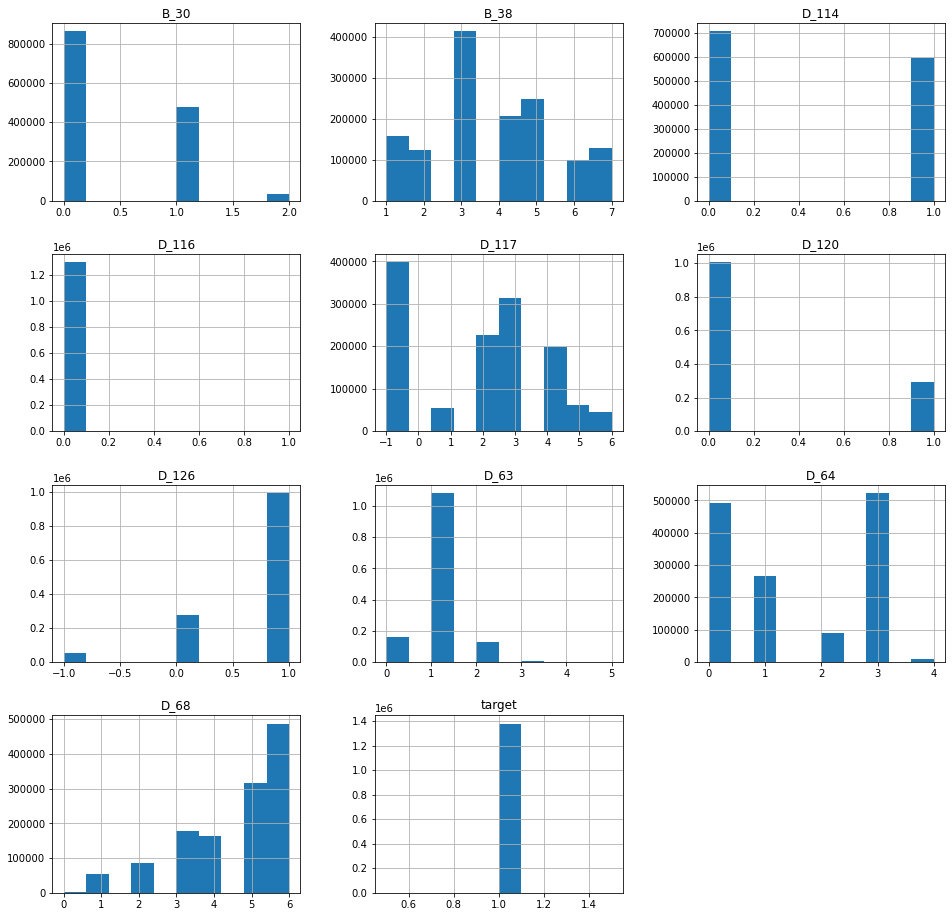

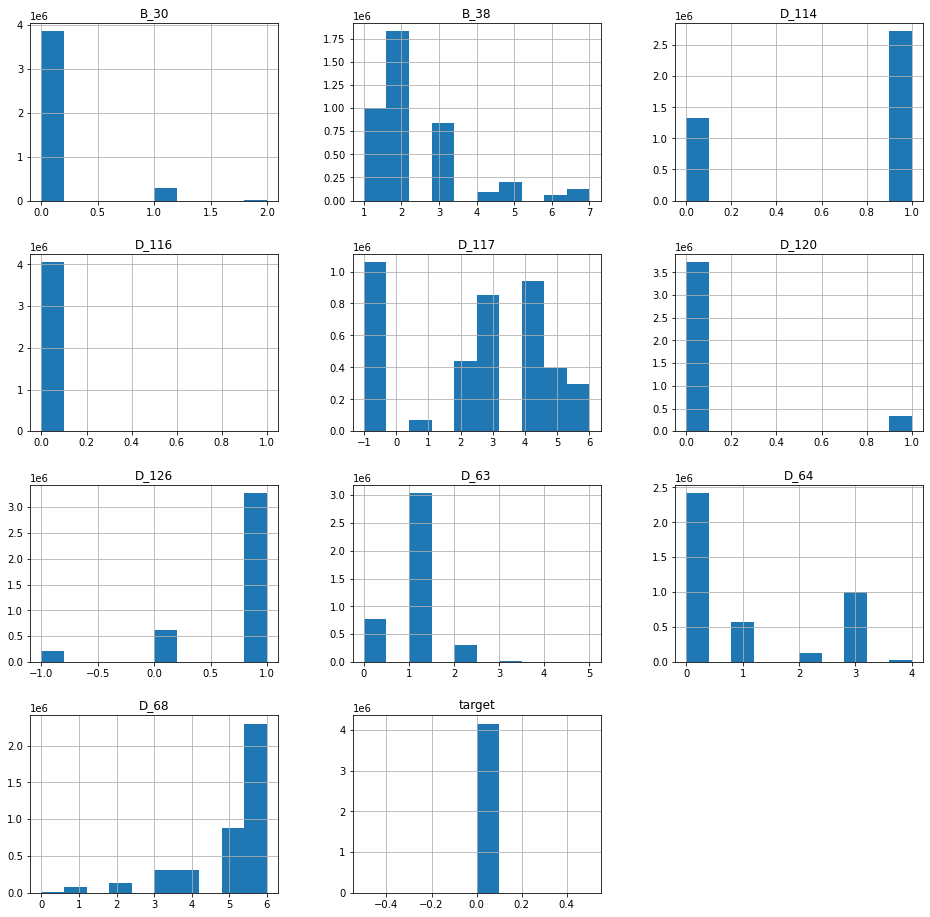

In [38]:
df[df['target'] == 1][categorical_variables].hist(figsize = (16,16))
df[df['target'] == 0][categorical_variables].hist(figsize = (16,16))

In [18]:
df.to_pickle('phase_1.pkl')

In [19]:
comp = {}
for col in df.columns:
    #comp.append(completeness(df[col]))
    comp[col] =completeness(df[col]) 
    #print('Completeness of ' + str(col) +': ' + '{:.2%}'.format(completeness(df[col])))
comp = {k: v for k, v in sorted(comp.items(), key=lambda item: item[1])}
comp

{'D_68': 0.9608596370102528,
 'D_114': 0.9680525055722269,
 'D_116': 0.9680525055722269,
 'D_117': 0.9680525055722269,
 'D_120': 0.9680525055722269,
 'D_126': 0.9788814905889973,
 'B_30': 0.999635538667883,
 'B_38': 0.999635538667883,
 'customer_ID': 1.0,
 'S_2': 1.0,
 'P_2': 1.0,
 'D_39': 1.0,
 'B_1': 1.0,
 'B_2': 1.0,
 'R_1': 1.0,
 'S_3': 1.0,
 'D_41': 1.0,
 'B_3': 1.0,
 'D_43': 1.0,
 'D_44': 1.0,
 'B_4': 1.0,
 'D_45': 1.0,
 'B_5': 1.0,
 'R_2': 1.0,
 'D_46': 1.0,
 'D_47': 1.0,
 'D_48': 1.0,
 'B_6': 1.0,
 'B_7': 1.0,
 'B_8': 1.0,
 'D_50': 1.0,
 'D_51': 1.0,
 'B_9': 1.0,
 'R_3': 1.0,
 'D_52': 1.0,
 'P_3': 1.0,
 'B_10': 1.0,
 'S_5': 1.0,
 'B_11': 1.0,
 'S_6': 1.0,
 'D_54': 1.0,
 'R_4': 1.0,
 'S_7': 1.0,
 'B_12': 1.0,
 'S_8': 1.0,
 'D_55': 1.0,
 'D_56': 1.0,
 'B_13': 1.0,
 'R_5': 1.0,
 'D_58': 1.0,
 'S_9': 1.0,
 'B_14': 1.0,
 'D_59': 1.0,
 'D_60': 1.0,
 'D_61': 1.0,
 'B_15': 1.0,
 'S_11': 1.0,
 'D_62': 1.0,
 'D_63': 1.0,
 'D_64': 1.0,
 'D_65': 1.0,
 'B_16': 1.0,
 'B_17': 1.0,
 'B_18': 1.

## Continous variable analysis

In [27]:
continous_variables = [x for x in df.columns if x not in categorical_variables[:-1]]

In [7]:
plot_df = df[continous_variables[2:]]

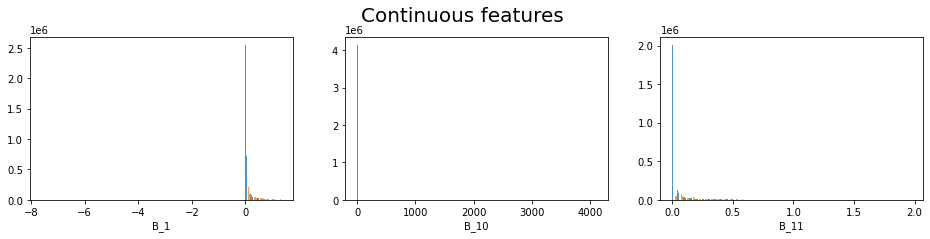

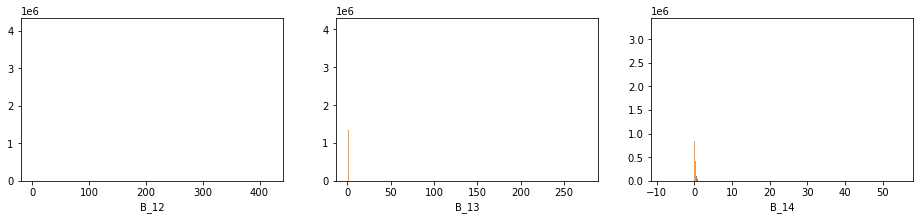

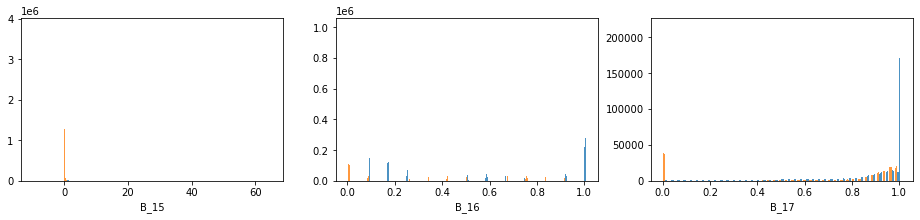

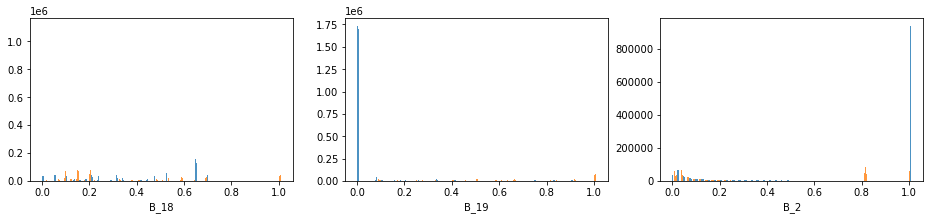

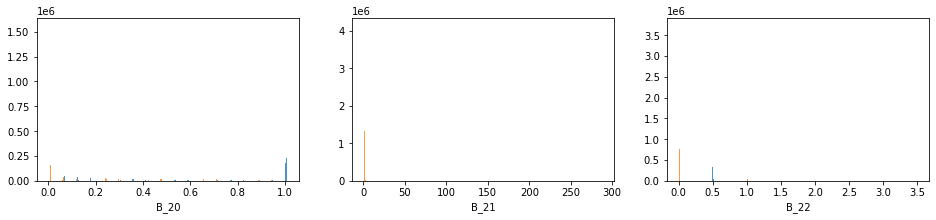

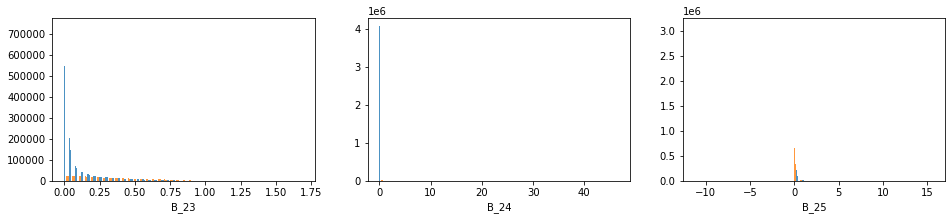

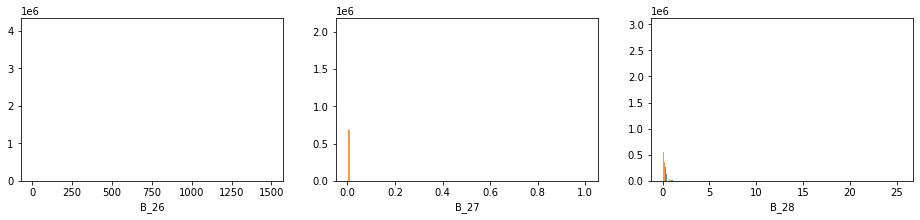

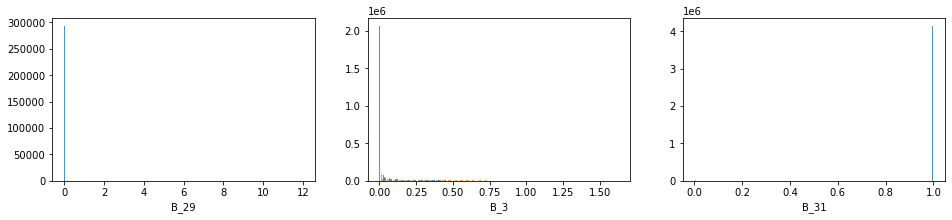

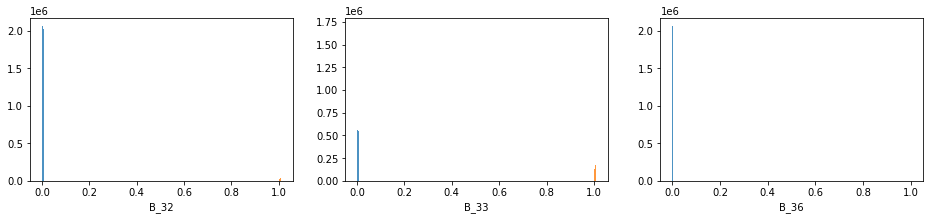

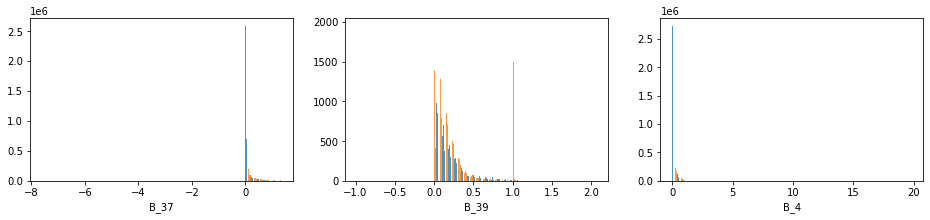

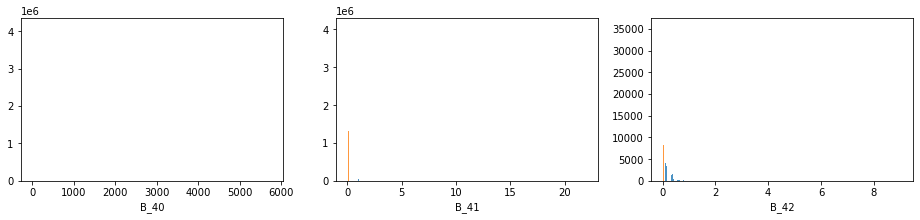

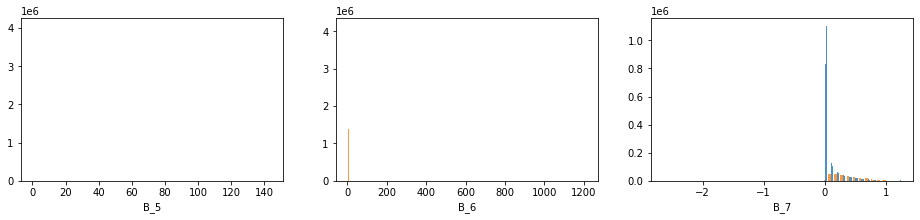

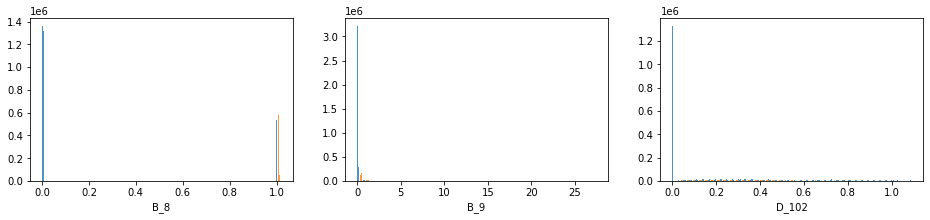

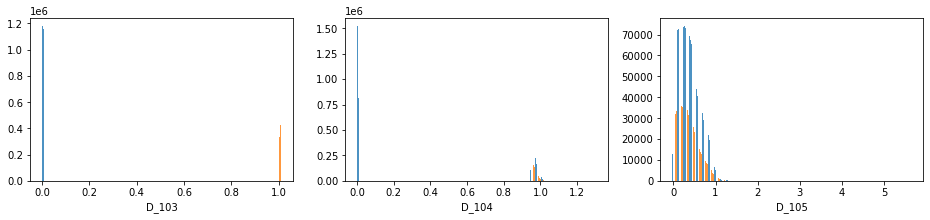

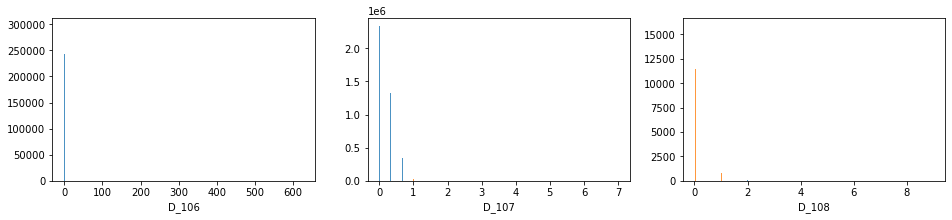

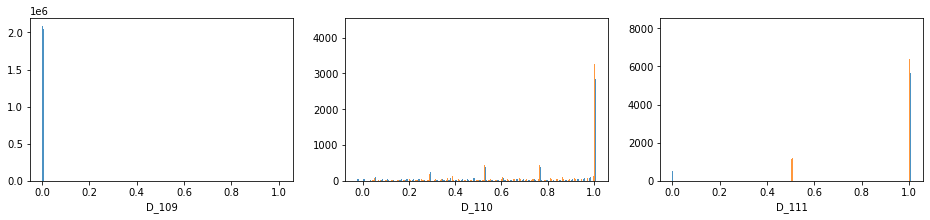

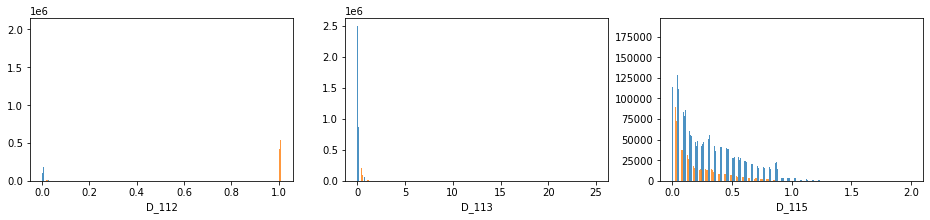

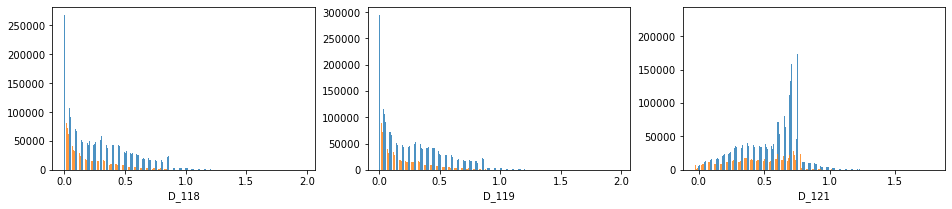

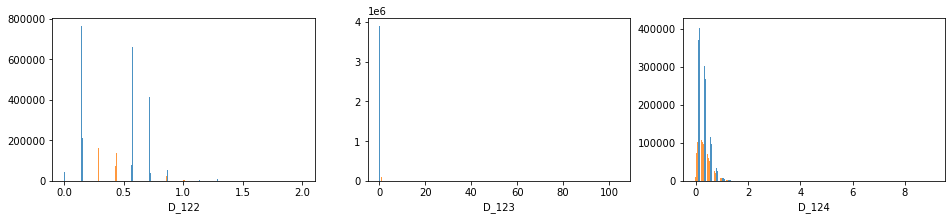

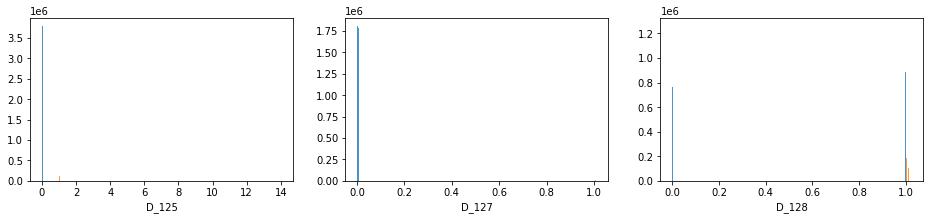

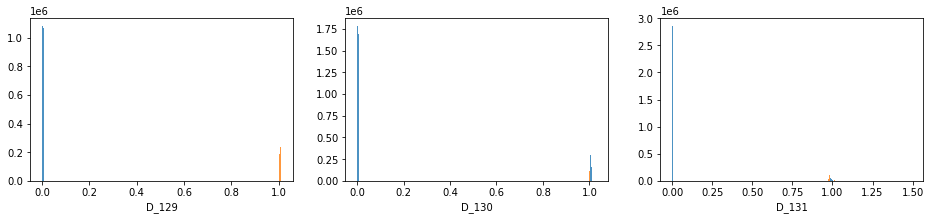

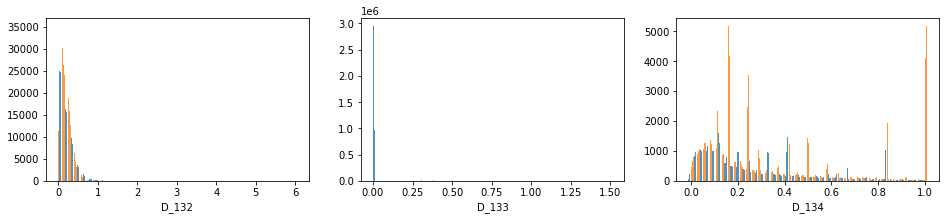

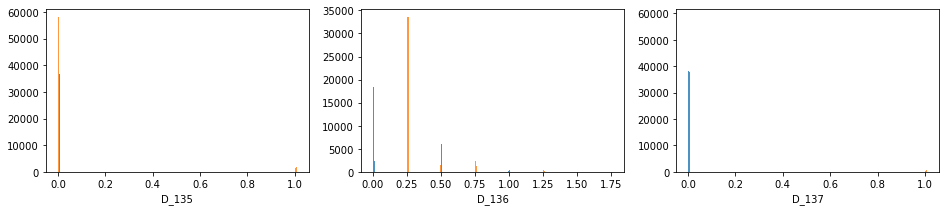

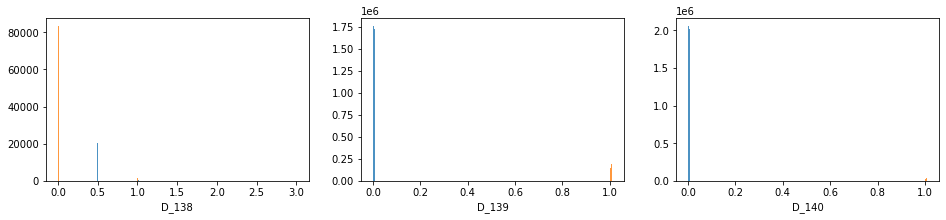

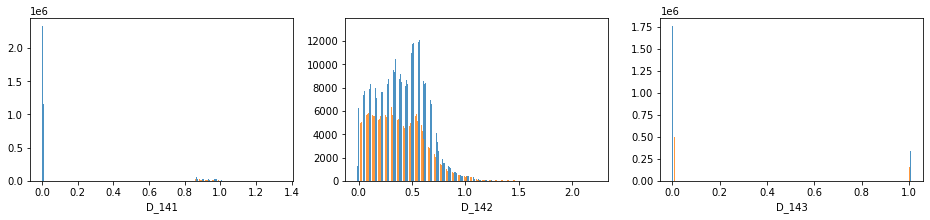

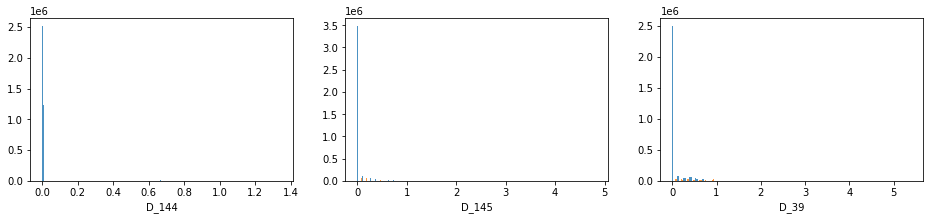

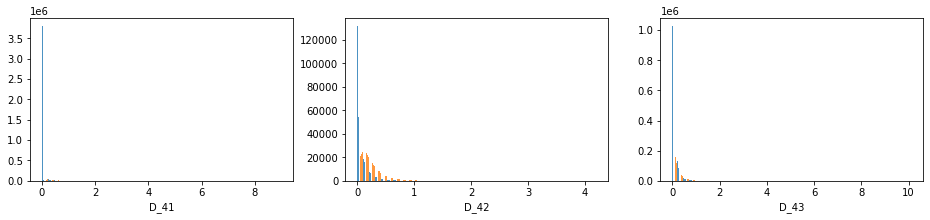

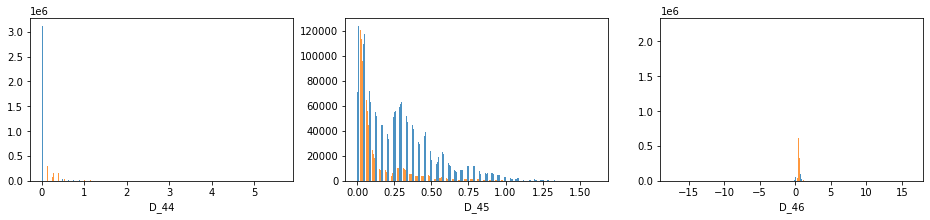

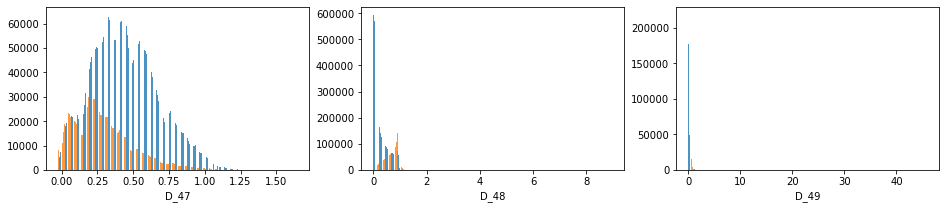

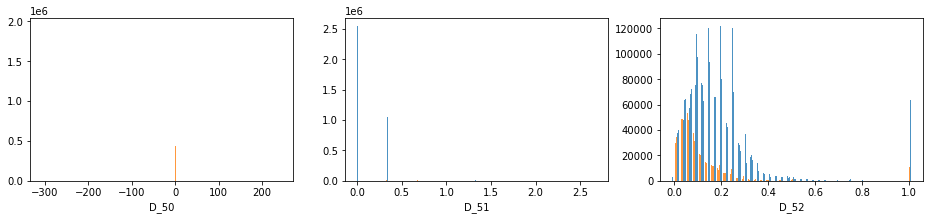

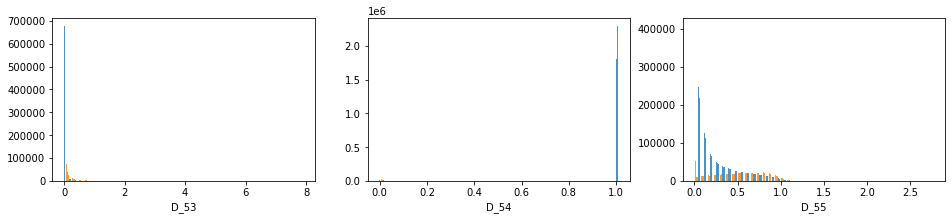

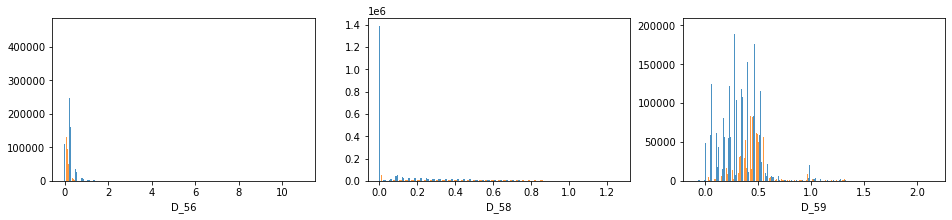

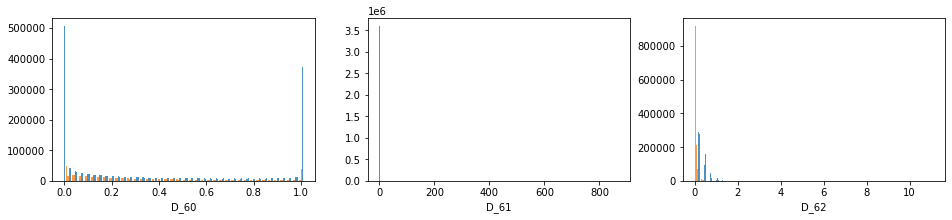

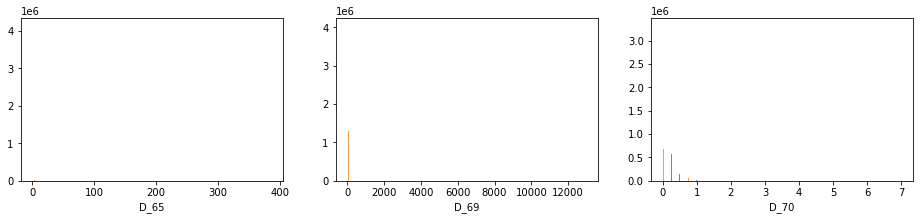

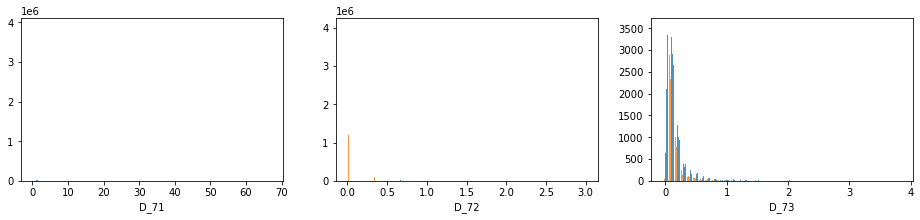

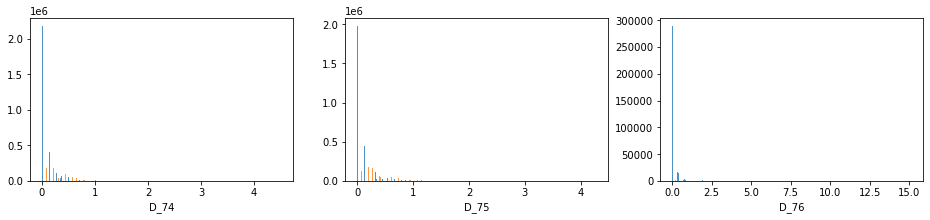

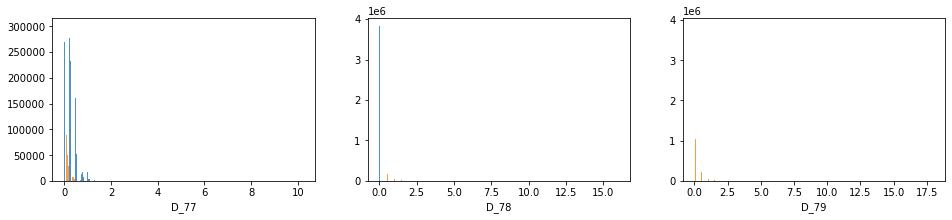

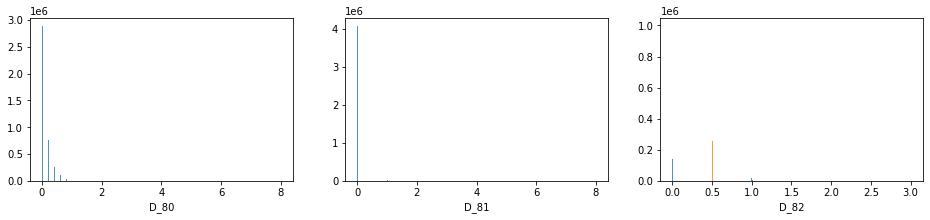

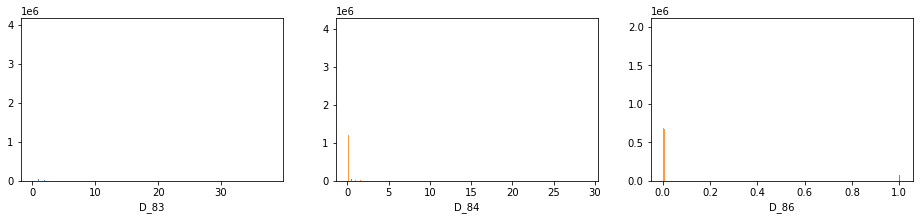

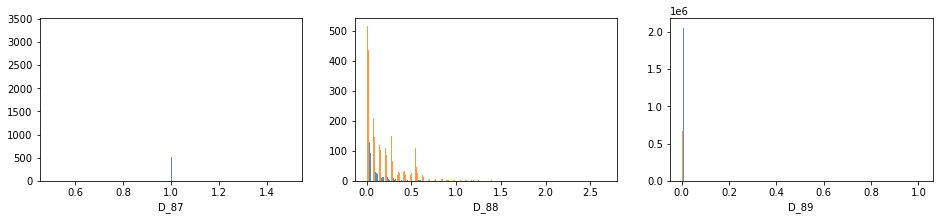

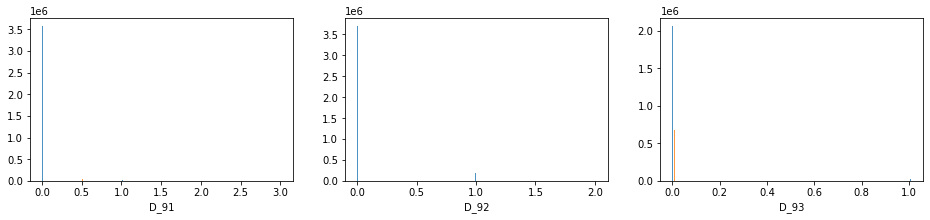

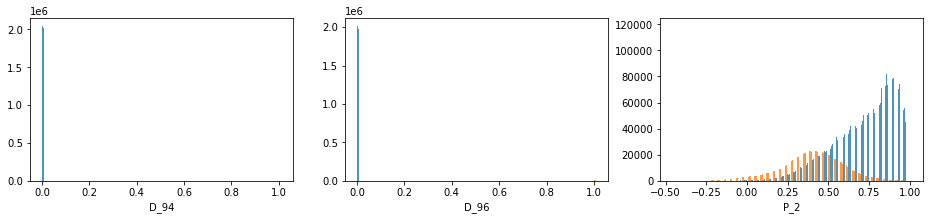

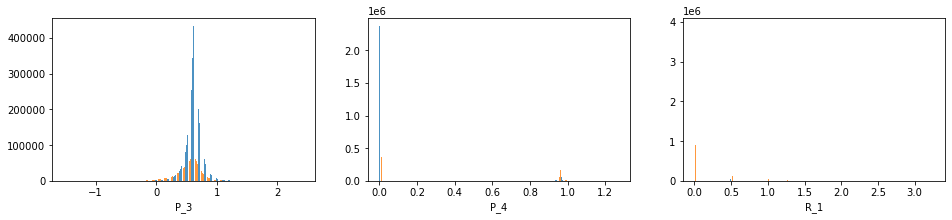

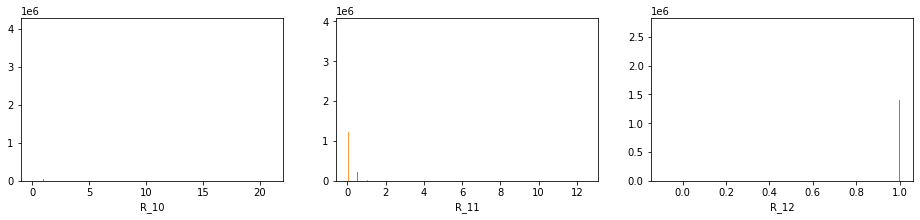

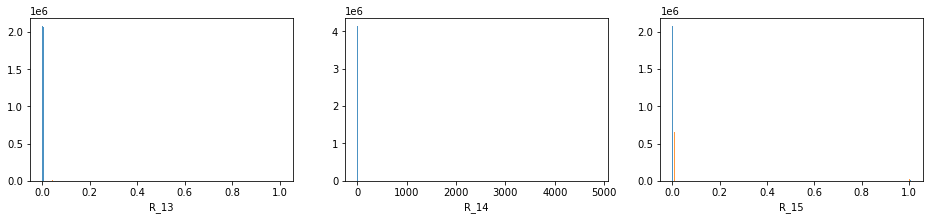

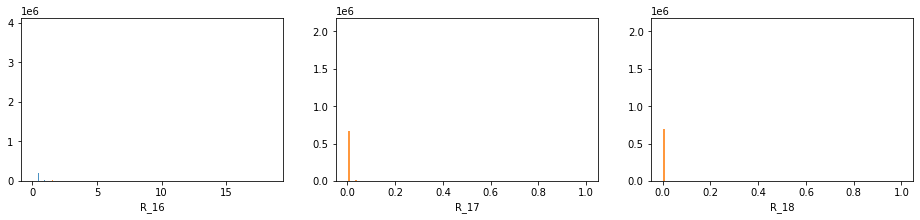

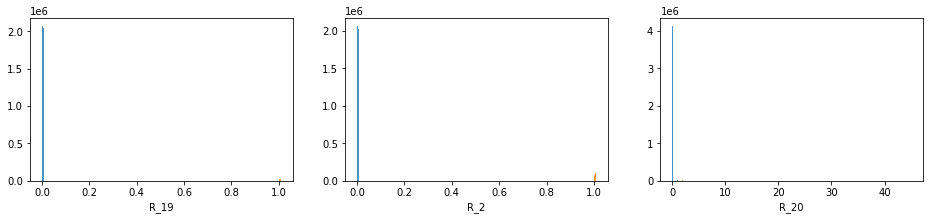

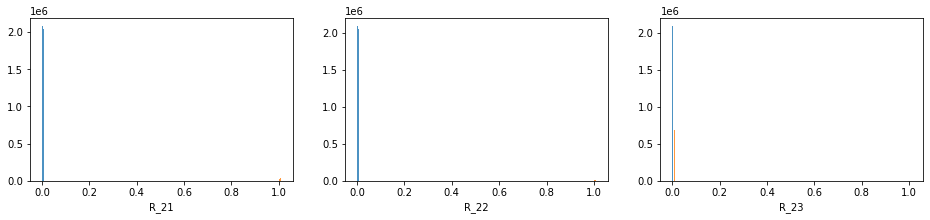

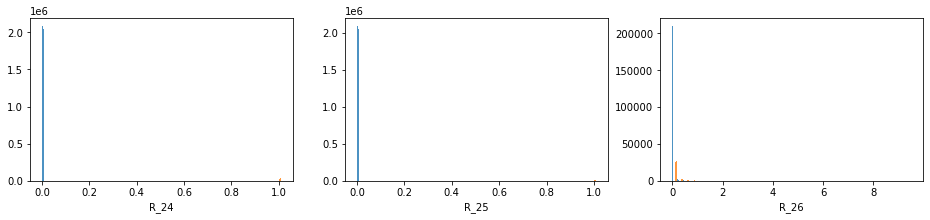

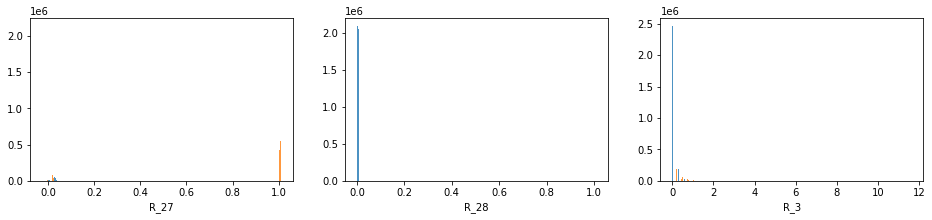

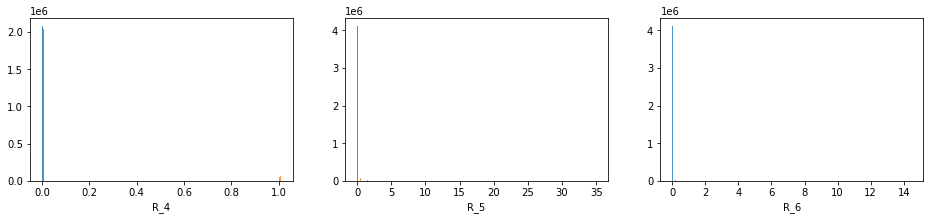

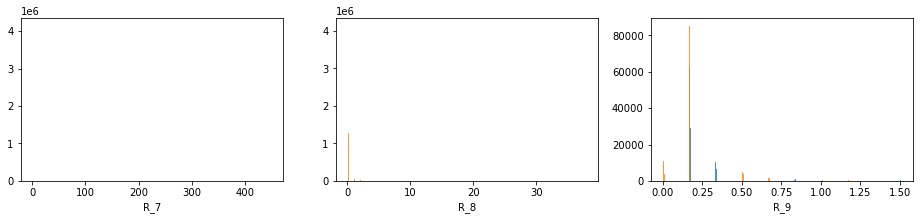

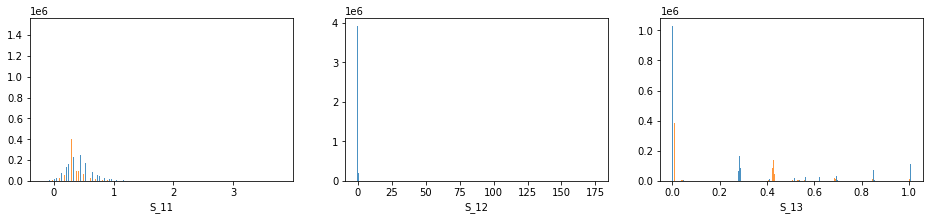

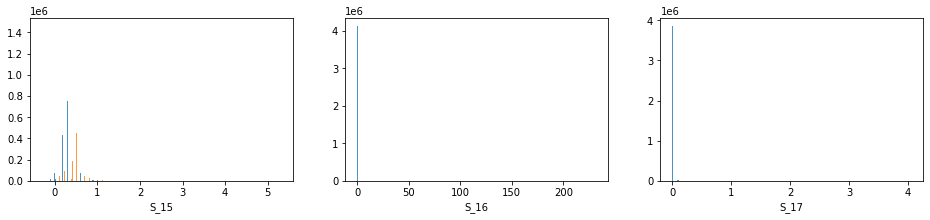

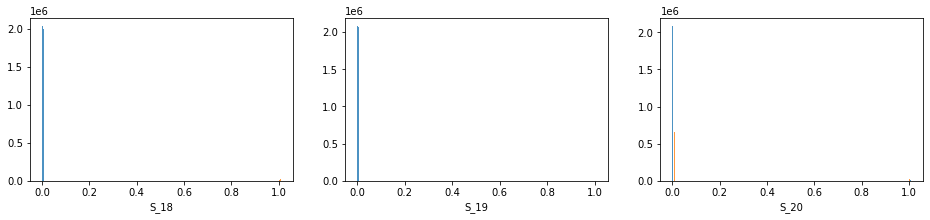

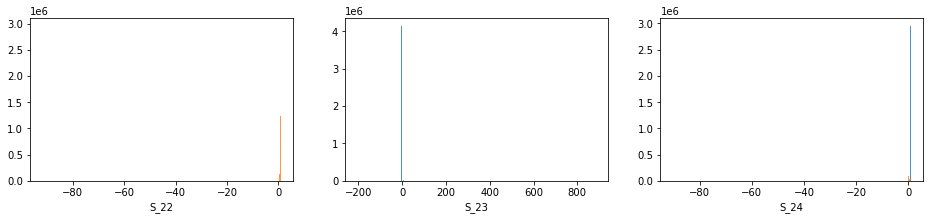

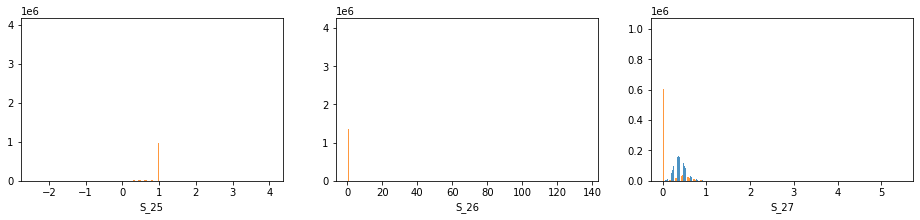

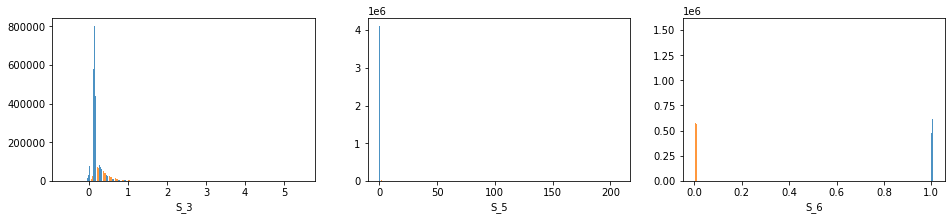

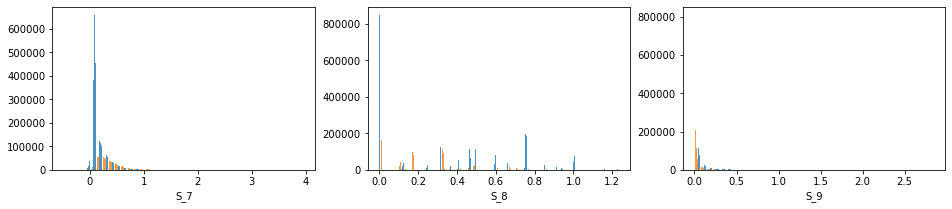

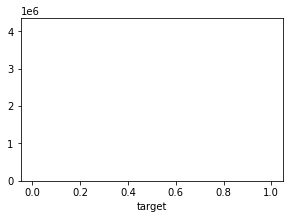

In [22]:
# print(cont_features)
ncols = 3
for i, f in enumerate(sorted(continous_variables[2:])):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0: plt.suptitle('Continuous features', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    plt.hist([plot_df.loc[plot_df['target'] == 0][f], plot_df.loc[plot_df['target'] == 1][f]], bins = 200,
         histtype='bar',
         stacked=False,  
         fill=True,
         label=['Paid', 'Default'],
         alpha=0.8)
    plt.xlabel(f)
plt.show()

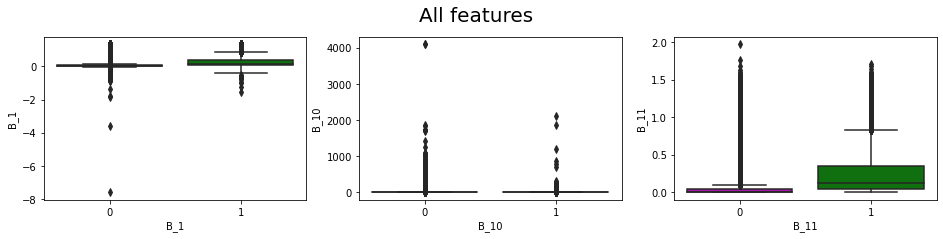

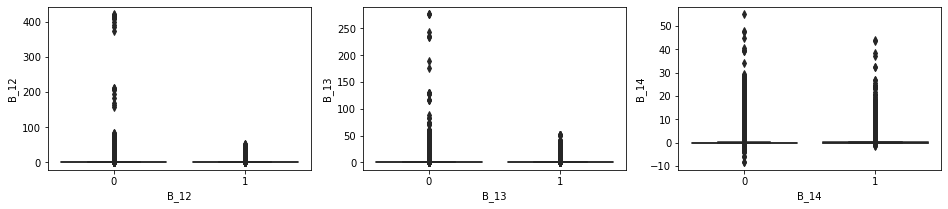

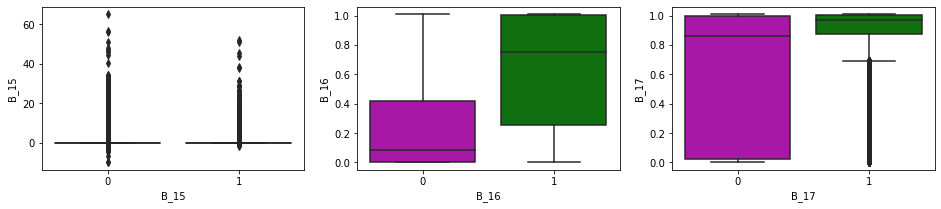

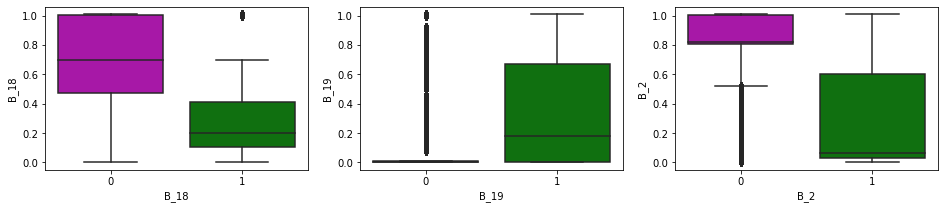

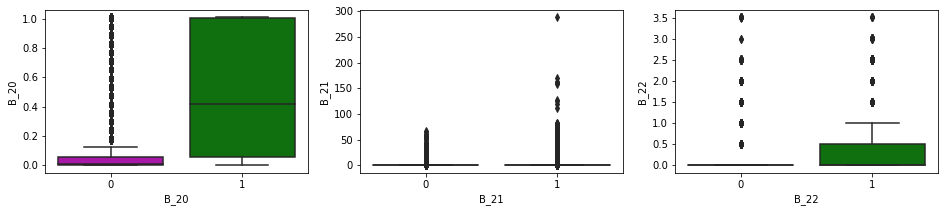

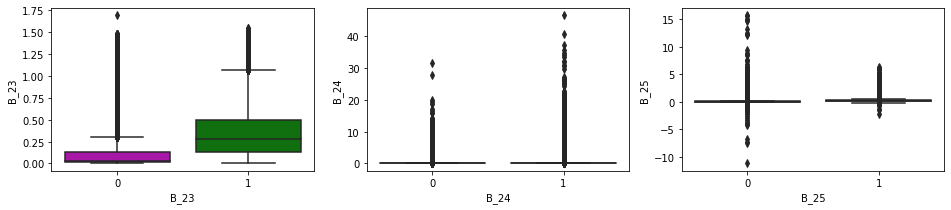

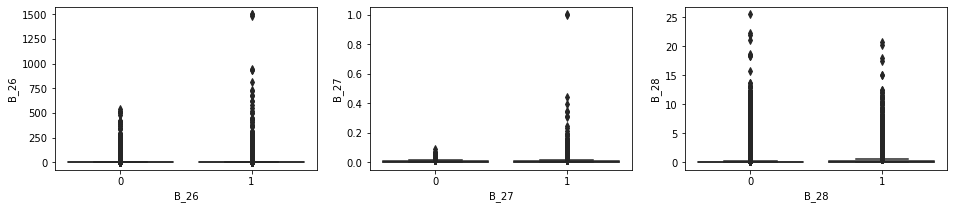

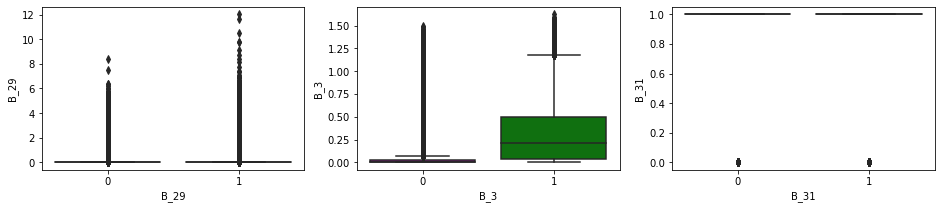

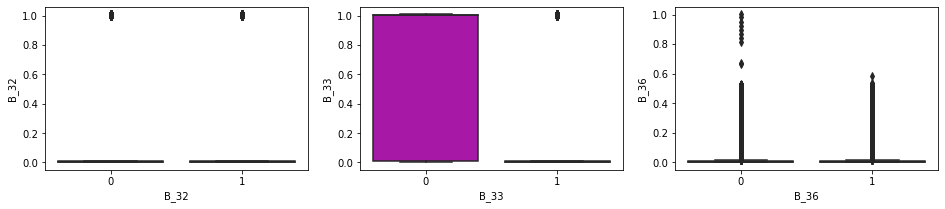

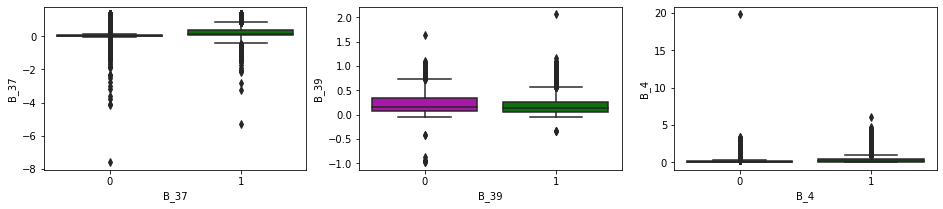

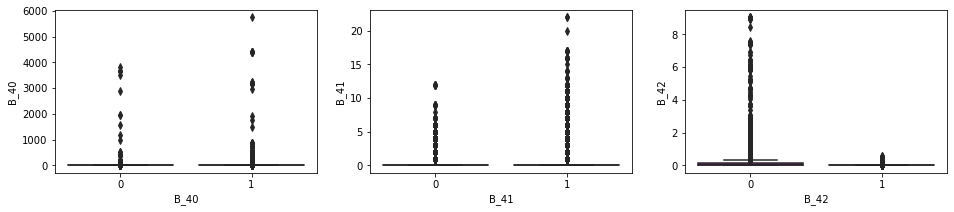

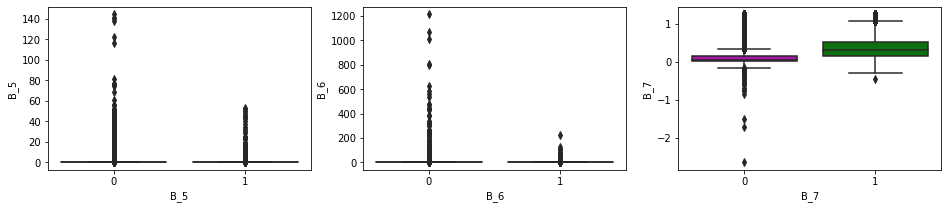

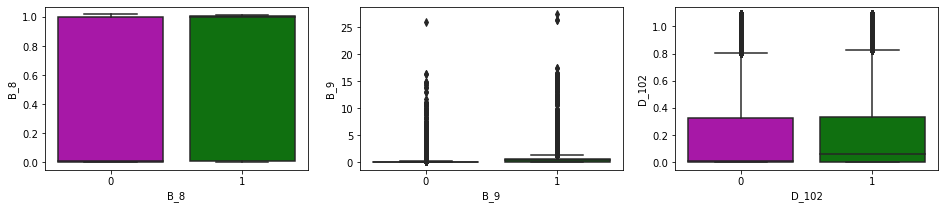

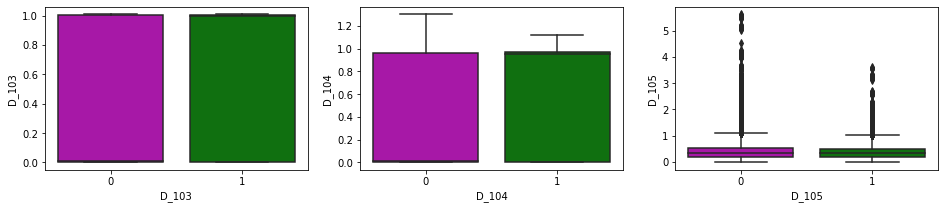

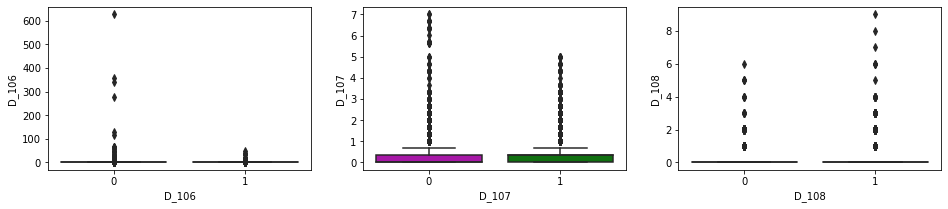

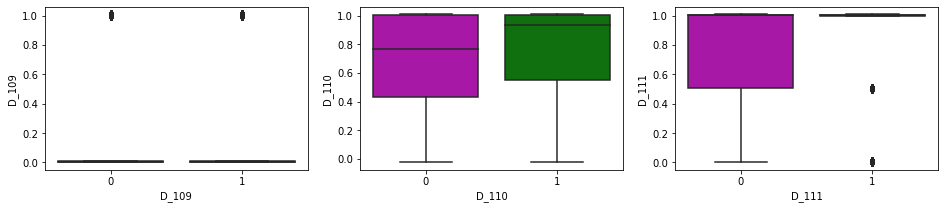

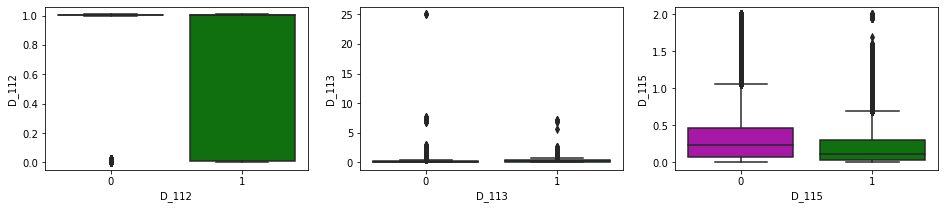

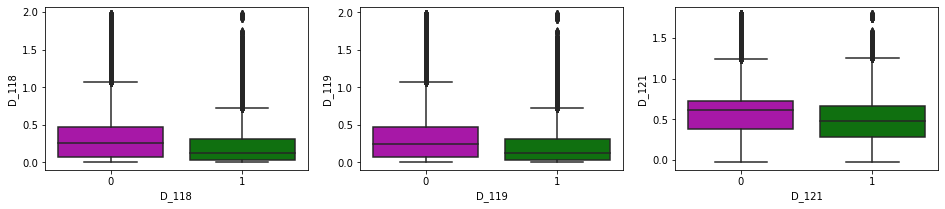

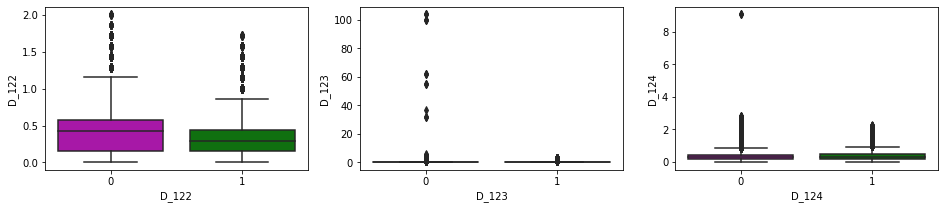

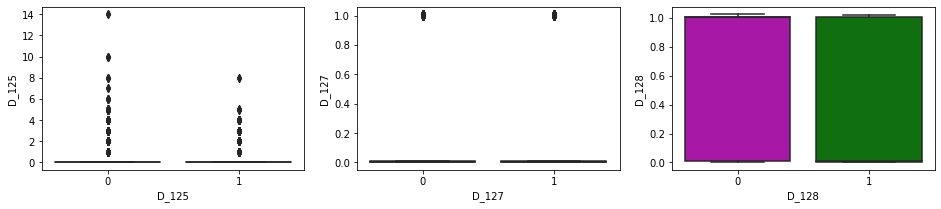

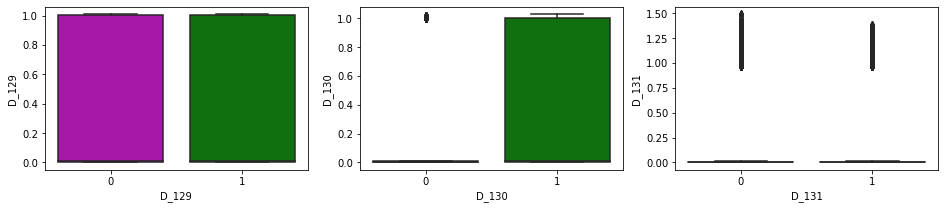

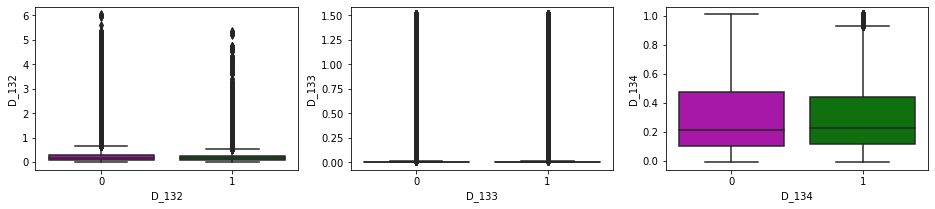

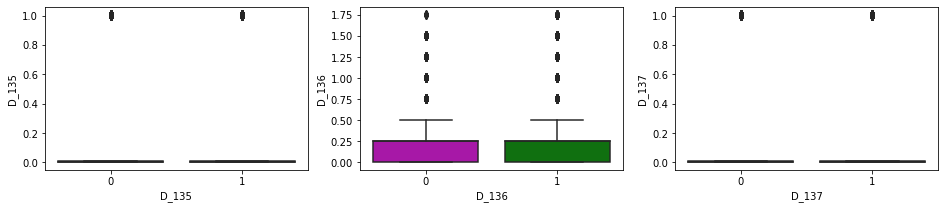

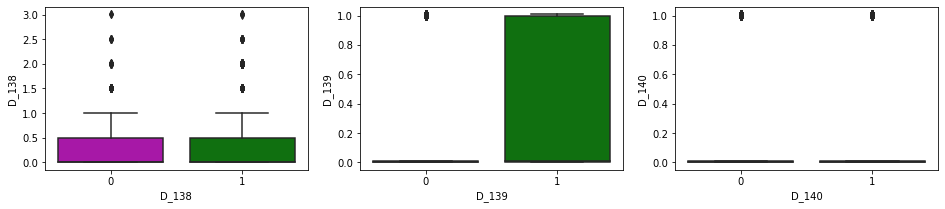

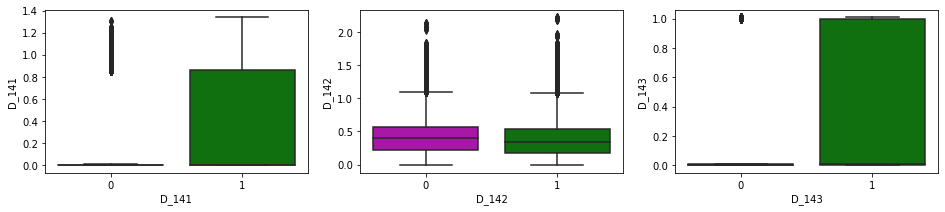

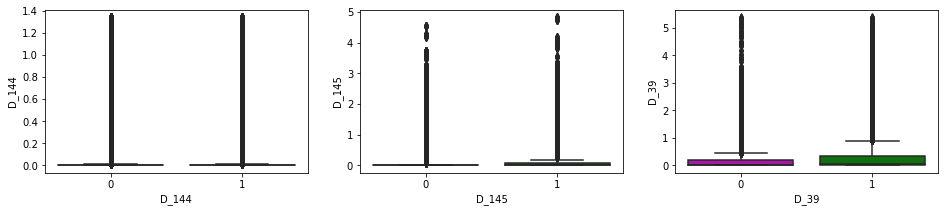

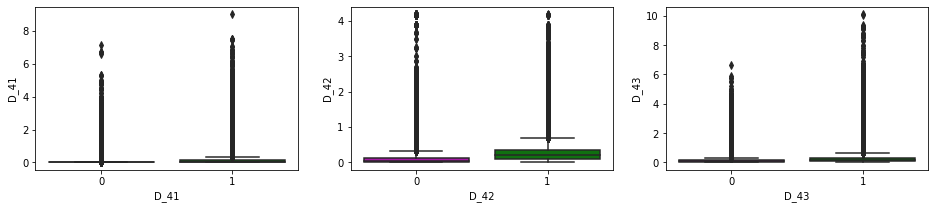

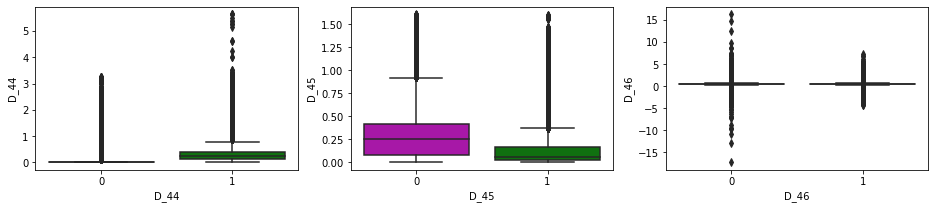

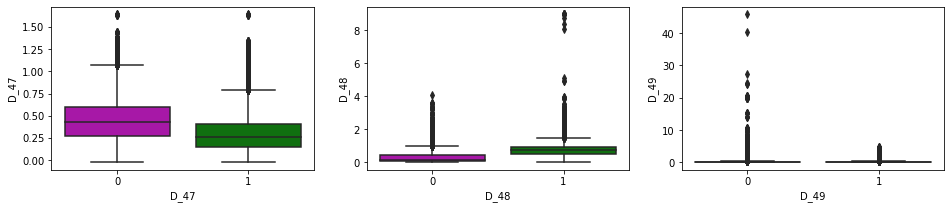

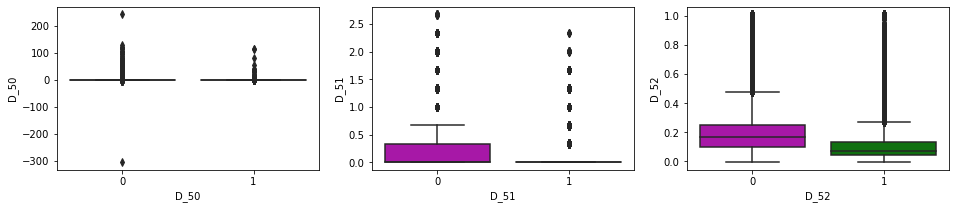

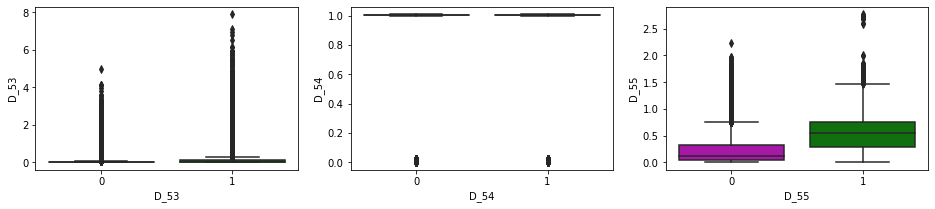

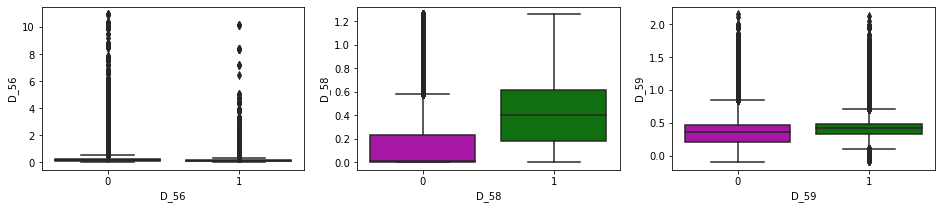

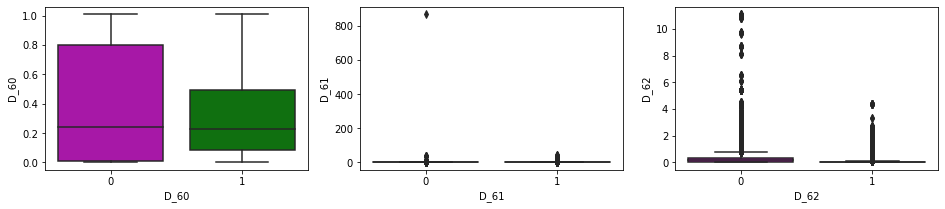

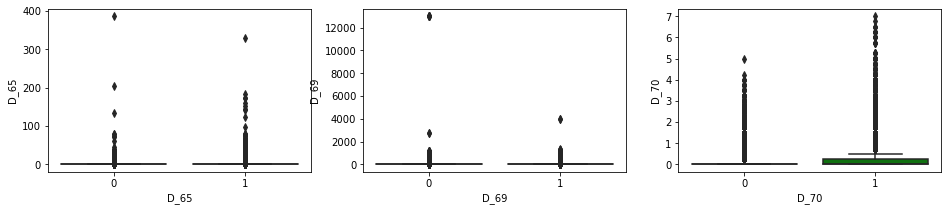

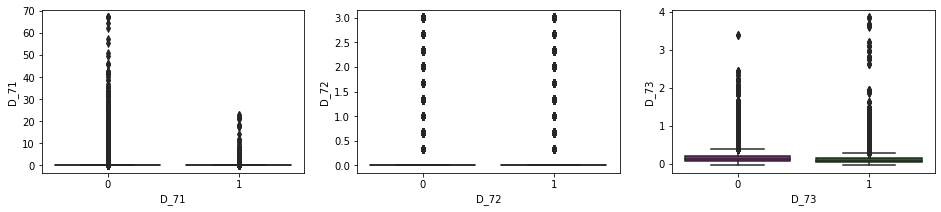

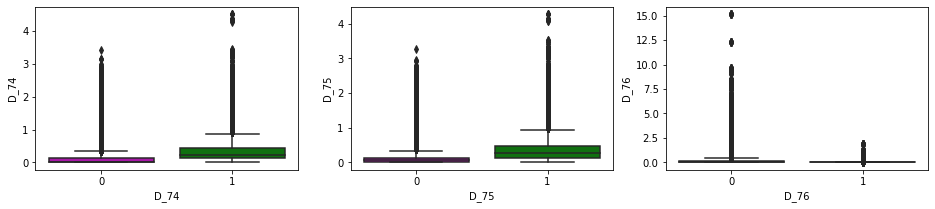

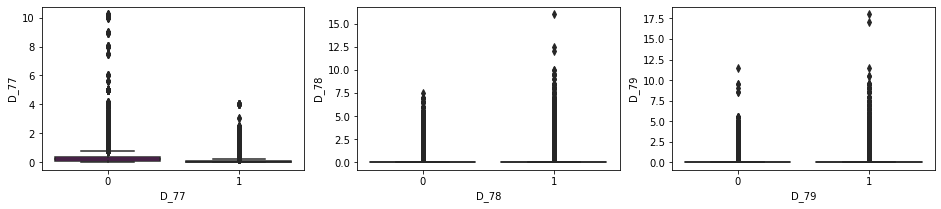

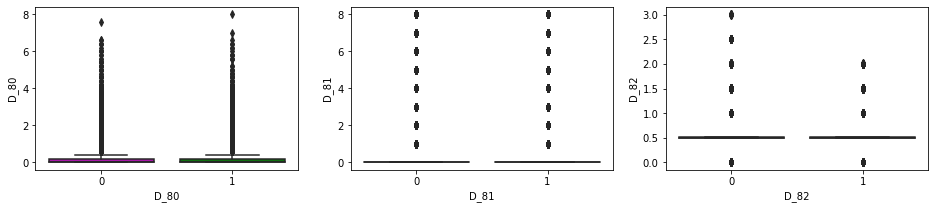

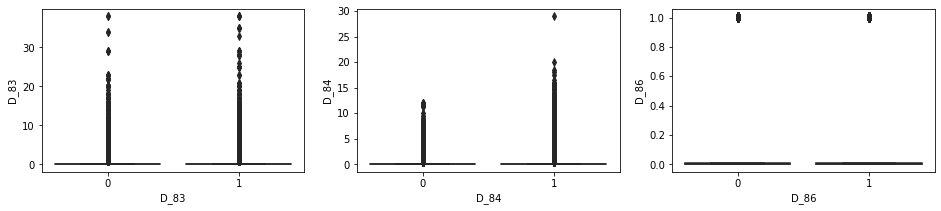

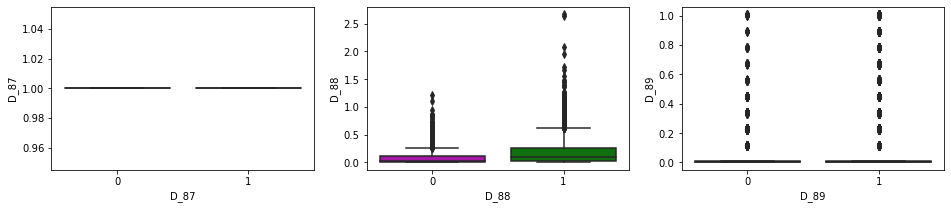

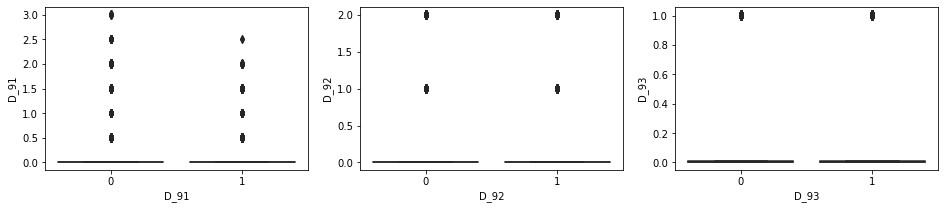

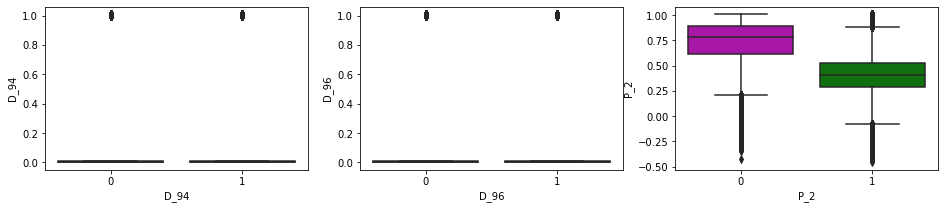

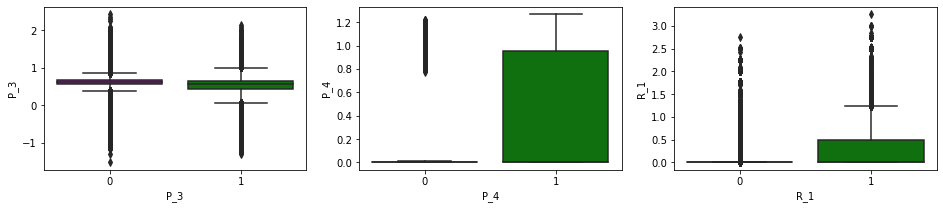

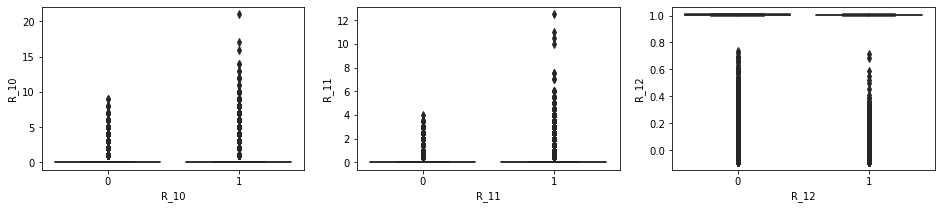

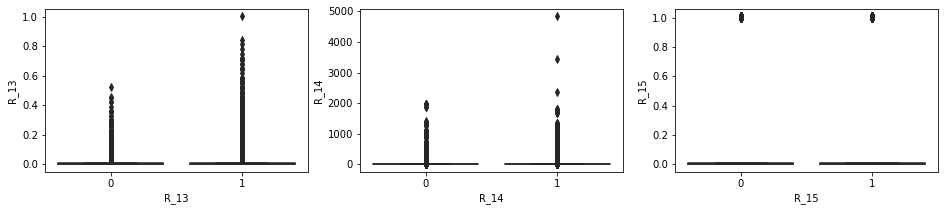

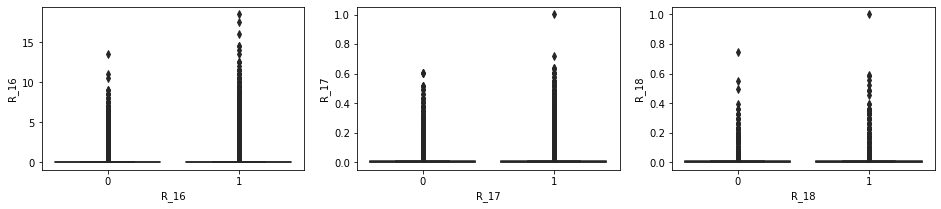

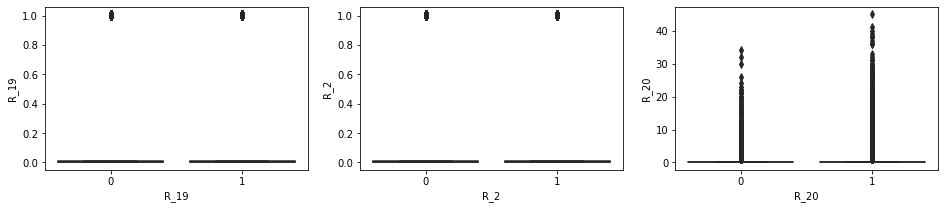

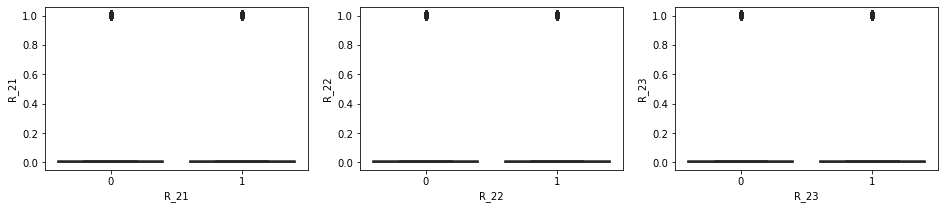

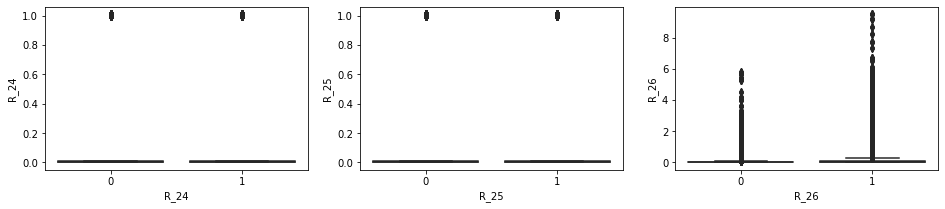

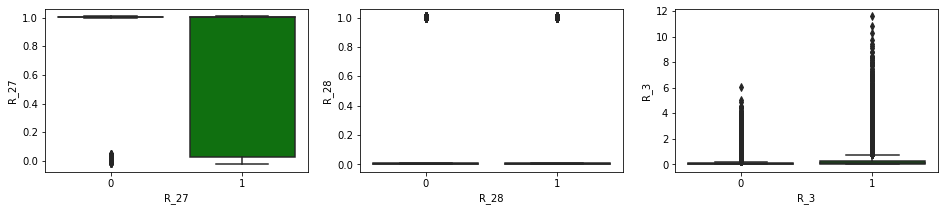

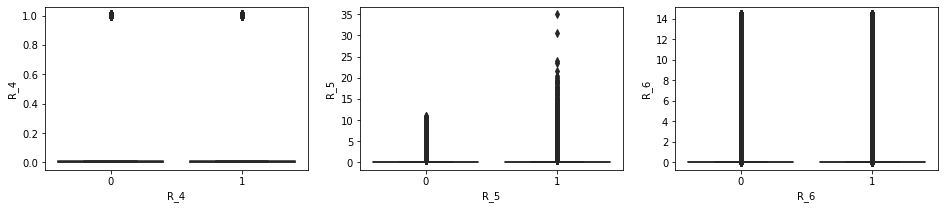

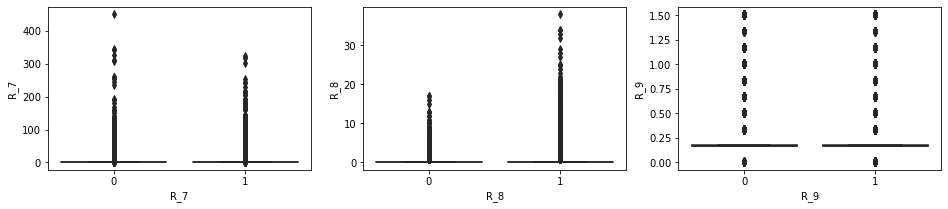

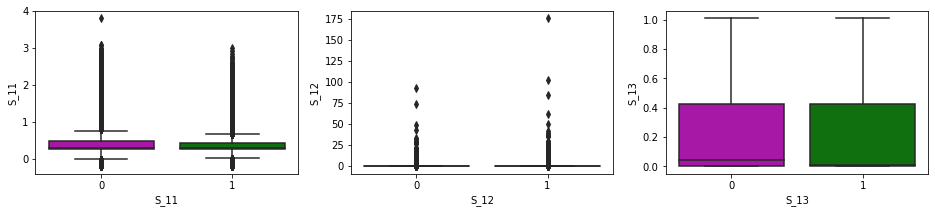

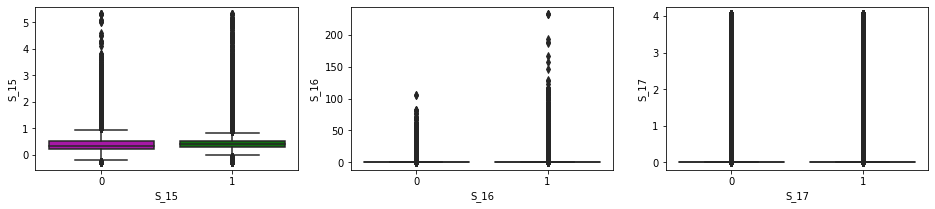

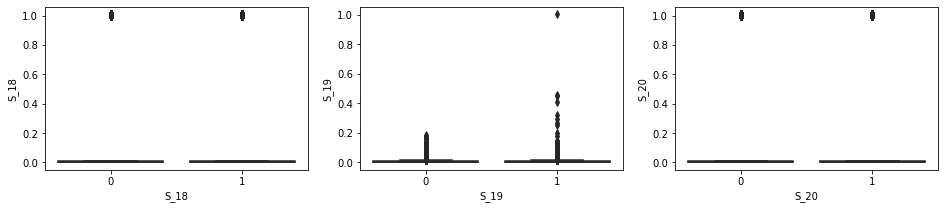

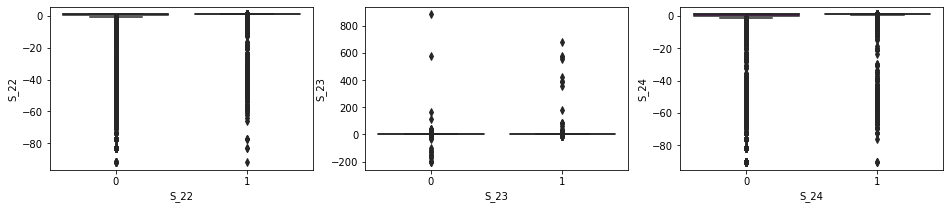

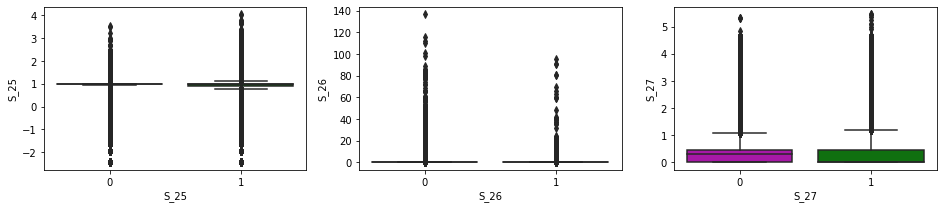

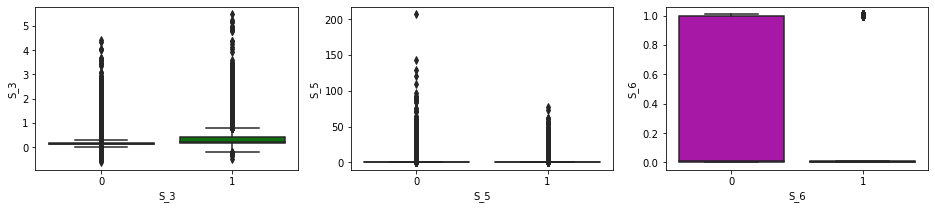

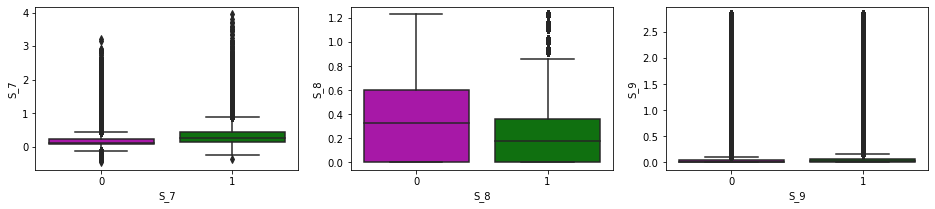

In [23]:
# print(cont_features)
ncols = 3
for i, f in enumerate(sorted(continous_variables[2:-1])):
    if i % ncols == 0: 
        if i > 0: plt.show()
        plt.figure(figsize=(16, 3))
        if i == 0: plt.suptitle('All features', fontsize=20, y=1.02)
    plt.subplot(1, ncols, i % ncols + 1)
    sns.boxplot(y=f, #y="total_bill",
            x="target", palette=["m", "g"],
            data=plot_df)
    plt.xlabel(f)
plt.show()

In [10]:
 
gc.collect()

4210

# Decision making - filling missing values, dropping columns, handling outliers

## Filling missing values & dropping columns

- 'D_87': 0.000698731670948545 <b> DROP </b>
- 'D_88': 0.0010854294831500813, <b> DROP </b>
- 'D_108': 0.005231538704763, <b> DROP </b>

- 'D_110': 0.005664698105433818, <b> DROP </b>
- 'D_111': 0.005664698105433818, <b> DROP </b>

- 'B_39': 0.006080140635793393, <b> DROP </b>
- 'D_73': 0.01009789293984526, <b> DROP </b>
- 'B_42': 0.012922106694970271,<b> DROP </b>

- 'D_134': 0.03519854012988635, <b> DROP </b>
- 'D_135': 0.03519854012988635, <b> DROP </b>
- 'D_136': 0.03519854012988635, <b> DROP </b>
- 'D_137': 0.03519854012988635, <b> DROP </b>
- 'D_138': 0.03519854012988635, <b> DROP </b>

- 'R_9': 0.05650108805085682, <b> DROP </b>
- 'B_29': 0.06895405925136099, <b> DROP </b>
- 'D_106': 0.09786744924613813, <b> DROP </b>
- 'D_132': 0.09808945247820147, <b> DROP </b>
- 'D_49': 0.09862403192218461, <b> DROP </b>
- 'R_26': 0.11015283331624921, <b> DROP </b>
- 'D_76': 0.11253774100141174, <b> DROP </b>
- 'D_66': 0.11269267322443967, <b> DROP </b>
- 'D_42': 0.1430572195252204, <b> DROP </b>
- 'D_142': 0.17073422507042005, <b> DROP </b>
- 'D_53': 0.26157078856885835, <b> DROP </b>
- 'D_82': 0.2662659399857289, <b> DROP </b>
- 'D_50': 0.4319027683694568, hard decision, prob some smarter inputation
- 'B_17': 0.4327712565834896, target dependend inputation???! the outlier occur only for defaults, meaning that this feature has standard distribution when no default occurs
- 'D_105': 0.453772436924778, some form of target dependend inputation
- 'D_56': 0.4592841914354841, np.nanmedian(df['D_56']) groupped
- 'S_9': 0.4696431370358338, np.nanmedian(df['D_56']) groupped
- 'D_77': 0.5455239502257183, median?
- 'D_43': 0.7001878892174946, median?
- 'S_27': 0.7467328192909961, median?
- 'D_46': 0.7809437342932262, mean
- 'S_3': 0.8155015745416528, mean
- 'S_7': 0.8155015745416528, mean
- 'D_62': 0.862936325387317, mean
- 'D_48': 0.8700657386280742, mean
- 'D_61': 0.891881533434898, mean
- 'P_3': 0.9454949524094131, mean groupped

- 'D_44': 0.9504074066641827,  mean
- 'D_78': 0.9504074066641827, mean

- 'D_64': 0.9606898804671685, mean
- 'D_68': 0.9608596370102528, mean

- 'D_69': 0.964842317142464, mean
- 'D_83': 0.964842317142464, mean

- 'D_55': 0.9665905022027674, mean

all mean ---> this group is going to get killed due to high correlations
- 'D_113': 0.9680525055722269,
- 'D_114': 0.9680525055722269,
- 'D_115': 0.9680525055722269,
- 'D_116': 0.9680525055722269,
- 'D_117': 0.9680525055722269,
- 'D_118': 0.9680525055722269,
- 'D_119': 0.9680525055722269,
- 'D_120': 0.9680525055722269,
- 'D_121': 0.9680525055722269,
- 'D_122': 0.9680525055722269,
- 'D_123': 0.9680525055722269,
- 'D_124': 0.9680525055722269,
- 'D_125': 0.9680525055722269,

- 'D_91': 0.9715778011953825,
- 'R_27': 0.9767325065339999,
- 'D_126': 0.9788814905889973,
- 'D_59': 0.9807057858778827,

all mean ---> this group is going to get killed due to high correlations
- 'D_103': 0.9816417066697327,
- 'D_104': 0.9816417066697327,
- 'D_107': 0.9816417066697327,
- 'D_128': 0.9816417066697327,
- 'D_129': 0.9816417066697327,
- 'D_130': 0.9816417066697327,
- 'D_131': 0.9816417066697327,
- 'D_139': 0.9816417066697327,
- 'D_141': 0.9816417066697327,
- 'D_143': 0.9816417066697327,
- 'D_145': 0.9816417066697327,

- 'D_70': 0.9828404879659967,
- 'D_79': 0.9862714141370863,
- 'B_13': 0.9910477377454848,
- 'P_2': 0.9916866297830352,
- 'D_133': 0.9922776139569889,
- 'D_144': 0.9926371941105507,
- 'D_102': 0.9926502105866978,
- 'D_140': 0.9926543686276892,


- 'D_52': 0.9946554710509051,
- 'D_84': 0.9946554710509051,
- 'D_89': 0.9946554710509051,

all mean ---> this group is treated this way just for 
- 'D_81': 0.9953561913501539,
- 'D_72': 0.9957139636598065,
- 'B_8': 0.9959742931827472,
- 'D_74': 0.9960637814562581,
- 'D_80': 0.9960637814562581,
- 'S_22': 0.9965607577469275,
- 'S_24': 0.9966386758194188,
- 'S_25': 0.9976774629297087,
- 'B_15': 0.9987484296615843,
- 'B_25': 0.9987484296615843,
- 'D_112': 0.9995209213640327,
- 'D_45': 0.999635357883492,


1st completeness group ----> basic input mean, new feature to be added
- 'B_2': 0.999635538667883,
- 'D_41': 0.999635538667883,
- 'B_3': 0.999635538667883,
- 'D_54': 0.999635538667883,
- 'B_16': 0.999635538667883,
- 'B_19': 0.999635538667883,
- 'B_20': 0.999635538667883,
- 'B_22': 0.999635538667883,
- 'B_26': 0.999635538667883,
- 'B_27': 0.999635538667883,
- 'B_30': 0.999635538667883,
- 'B_33': 0.999635538667883,
- 'B_38': 0.999635538667883,

- 'D_109': 0.9997112873276831, np.nanmean(df['D_109'].astype('float64'))
- 'B_41': 0.9998752587702576, np.nanmean(df['B_41'].astype('float64'))
- 'S_26': 0.9998853826961497, np.nanmean(df['S_26'].astype('float64'))
- 'S_23': 0.9999195509460357, np.nanmean(df['S_23'].astype('float64'))
- 'B_6': 0.9999578772369131, np.nanmean(df['B_6'].astype('float64'))
- 'R_20': 0.9999864411706801, np.nanmean(df['R_20'].astype('float64'))

- 'R_12': 0.9999898760741078, np.nanmean(df['R_12'].astype('float64'))
- 'B_37': 0.9999898760741078, np.nanmean(df['B_37'].astype('float64'))

- 'B_40': 0.9999904184272806, np.nanmean(df['B_40'].astype('float64'))

- 'R_7': 0.9999998192156091, np.nanmean(df['R_7'].astype('float64'))
- 'R_14': 0.9999998192156091, <b> np.nanmean(df['R_14'].astype('float64')) </b>

Additional:
- 'X_1' 1st group completeness binary flag

In [135]:
cors['D_56'].sort_values()

D_42     -0.204390
D_88     -0.195185
B_7      -0.165999
D_58     -0.165916
S_3      -0.163976
D_75     -0.162939
D_74     -0.157646
S_7      -0.157297
B_23     -0.155160
D_48     -0.153697
D_61     -0.151782
S_15     -0.151509
target   -0.146568
B_19     -0.133175
B_16     -0.132530
B_8      -0.126948
D_130    -0.122503
B_20     -0.121700
D_55     -0.116939
B_38     -0.116686
D_44     -0.116558
B_3      -0.115539
B_9      -0.115318
B_30     -0.112192
D_59     -0.110692
B_4      -0.107293
B_17     -0.105581
B_1      -0.105117
B_37     -0.104488
D_114    -0.101872
D_70     -0.099386
B_22     -0.096754
B_11     -0.094253
D_131    -0.094009
D_79     -0.083074
P_4      -0.080578
D_139    -0.073893
D_143    -0.073857
D_141    -0.072408
D_136    -0.069891
D_133    -0.068434
D_134    -0.063916
D_145    -0.063214
D_104    -0.061341
R_1      -0.061246
D_103    -0.061146
D_120    -0.058248
R_26     -0.056722
D_53     -0.052682
D_78     -0.050706
D_43     -0.050082
R_2      -0.049619
B_32     -0.

In [136]:
np.nanmean(df['D_56'].astype('float64'))

0.203709443321177

In [137]:
np.nanmedian(df['D_56'])

0.1494

<AxesSubplot:>

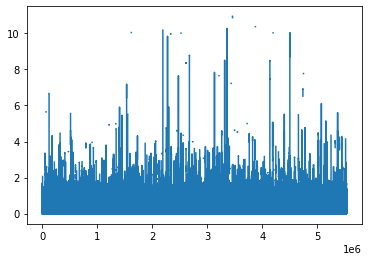

In [139]:
df['D_56'].plot()

### Suspicious group of similar completeness

In [113]:
cors.loc[['B_2',
 'D_41',
 'B_3',
 'D_54',
 'B_16',
 'B_19',
 'B_20',
 'B_22',
 'B_26',
 'B_27',
 'B_30',
 'B_33',
 'B_38', 'target']][['B_2',
 'D_41',
 'B_3',
 'D_54',
 'B_16',
 'B_19',
 'B_20',
 'B_22',
 'B_26',
 'B_27',
 'B_30',
 'B_33',
 'B_38']].style.background_gradient(cmap='coolwarm')

Some correlations are very high, so the will be transformed/ removed later on, but some are not, which leads me to an idea for a feature based on completeness.